In [1]:
### Set up
from itertools import product, permutations
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse
)
import polars as pl
import torch
import functorch


from sngrok.fourier import slow_ft_1d, slow_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.permutations import Permutation, make_permutation_dataset, generate_subgroup
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

In [2]:

def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs

In [7]:
ckpt_dir = Path('experiments/')
model_seed = 0
data_seed = 13
run_name = f'model_{model_seed}_data_{data_seed}'
run_dir = ckpt_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(ckpt_dir / f'data_{data_seed}.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

out, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(out, targets)

linear_acts = cache['hook_linear']

In [8]:
def add_parens(perm):
    return '(' + ', '.join(list(perm)) + ')'

run_data = run_data.select(['permutation_left', 'permutation_right', 'permutation_target']).with_columns([
    pl.col('permutation_left').apply(add_parens),
    pl.col('permutation_right').apply(add_parens),
    pl.col('permutation_target').apply(add_parens),
])

In [9]:



linear_acts_df = pl.concat(
    [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(128)])],
    how='horizontal'
)


linear_acts_df.head()


permutation_left,permutation_right,permutation_target,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...",-1.460827,-1.501025,0.000547,-0.191209,-2.245387,0.332321,-0.555197,-1.673699,-6.706148,-1.729527,-2.594479,0.957544,-2.060869,0.899282,-0.208499,-7.215476,5.122505,9.462928,0.791446,-2.525337,4.079433,3.36364,0.952943,0.719875,-6.881929,-4.180217,2.100335,-3.520244,-1.333787,0.038566,0.183923,0.000408,0.172384,6.404066,...,-1.60121,-0.580091,0.000048,-0.000586,3.644683,-2.972074,-6.442329,0.709991,-2.502266,-2.539196,4.200221,-0.137556,-2.668712,-2.044834,0.120569,-9.822662,2.078621,1.906828,-0.929712,0.000339,0.771795,3.77874,4.783494,5.40868,-0.021473,-0.000449,0.289011,-5.47822,2.993537,1.19661,-0.001003,-2.430513,0.119836,-2.668422,-3.396948,0.157822,2.687176
"""(0, 1, 2, 3, 4...","""(0, 1, 3, 4, 2...","""(0, 1, 3, 4, 2...",2.658556,-3.189901,-2.400925,-3.46294,-1.156163,0.45349,0.231119,-1.320178,-7.162554,-0.875451,-4.481739,0.646758,-4.564584,2.807217,0.126275,-7.464751,-0.000191,13.075637,1.733989,0.434944,-0.052529,0.120049,2.034005,-1.204089,0.001982,-4.260046,-1.193294,2.891541,0.198057,-0.331886,-0.224863,3.548495,-0.426114,9.929518,...,-5.838993,1.048776,0.003601,0.004438,3.608675,1.503789,-6.439764,0.673966,-0.167285,-0.000762,-2.018269,0.305687,-2.669403,-5.705449,0.063673,-3.491467,-0.691816,1.457777,-1.98528,6.901495,0.736011,3.778199,1.569865,5.819768,0.202083,2.174434,-4.78499,-5.348203,5.870217,2.296402,-0.002538,-2.567721,-0.389446,0.000298,-2.567356,-0.142947,-0.000362
"""(0, 1, 2, 3, 4...","""(0, 1, 4, 2, 3...","""(0, 1, 4, 2, 3...",-1.954534,0.823208,3.30249,-0.581673,-0.789169,0.188193,-0.351799,-1.003736,-7.143355,-3.394559,-0.000451,1.997335,2.501626,-0.073066,-1.277224,-7.462008,-2.821397,2.894502,3.077947,0.003099,-0.313949,1.143229,-1.15634,-0.649978,3.792134,-0.276836,0.984018,6.425765,-0.681762,-0.449018,0.164596,-6.452546,0.064124,-0.000199,...,-6.028249,2.228605,0.000831,0.000205,3.749357,1.376265,-6.443043,0.709991,-0.475072,-7.155292,1.80288,3.017064,-2.67102,-6.426384,0.637728,-0.000026,-0.428394,0.027597,1.137008,10.70457,0.605077,3.778774,-1.725397,3.447678,-0.153475,-2.991674,-0.069907,-1.915869,4.656882,-0.589026,-0.000391,-2.587658,0.003728,1.94196,0.739877,0.30821,-1.956068
"""(0, 1, 2, 3, 4...","""(0, 2, 1, 4, 3...","""(0, 2, 1, 4, 3...",2.525165,-0.000029,2.131474,-3.323775,-1.006671,-0.169905,-0.269108,4.908621,-7.235497,-0.000997,-0.918438,-0.218082,-4.563705,2.929861,-3.823148,-7.457468,7.382986,13.07548,4.875835,0.335828,-0.136128,0.171783,3.139695,-0.152166,-9.915586,-0.717286,-0.000284,-6.348279,-1.520159,-5.888631,-0.016304,3.547102,0.042795,9.926098,...,-5.964311,0.554492,-0.000296,2.83743,4.185362,1.34765,-6.443207,0.745887,-0.246748,-0.000169,1.989146,4.798324,0.001063,-4.26481,-0.034484,-12.621214,-0.692784,0.025165,-3.071567,-3.042241,5.679511,3.777862,-1.729307,5.584023,0.104333,-1.929494,-5.28702,-0.542076,4.576999,0.924363,-0.00022,-3.098745,-0.038463,-0.801732,0.717607,0.044665,0.808124
"""(0, 1, 2, 3, 4...","""(0, 2, 3, 1, 4...","""(0, 2, 3, 1, 4...",-1.504695,-0.802096,0.994596,-0.212415,-2.904634,-0.79624,0.298242,0.308192,-7.134027,-4.277799,-1.815106,2.494598,-2.058209,0.751172,-1.322449,-7.434752,7.388819,9.4

In [10]:
S5 = Permutation.full_group(5)


In [11]:
from functools import reduce

def union(cosets):
    if len(cosets) == 0:
        return cosets
    else:
        return reduce(lambda x, y: set(x).union(set(y)), cosets)

def get_cosets(subgroup):
    S5 =  Permutation.full_group(5)
    all_s5 = set([s.sigma for s in S5])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_s5:
        left = S5.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def _coset_join(df1, df2):
    return df1.join(df2, on='permutation', how='inner')


def _coset_df(cosets, prefix):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), f'coset_rep_{prefix}': rep} for c in cos])
    return pl.DataFrame(data)






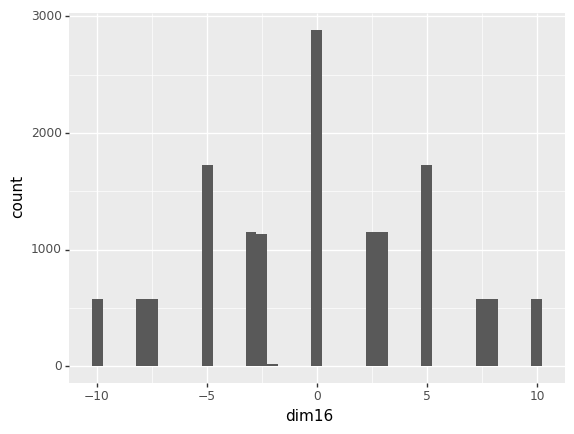

<ggplot: (684122779)>

In [12]:
col = 'dim16'
df = (
    linear_acts_df
    .select(['permutation_left', 'permutation_right', 'permutation_target', col])
)

ggplot(df, aes(x=col)) + geom_histogram(binwidth=0.5)

In [13]:
(
    df
    .filter(pl.col(col).abs() > 9.)
    .groupby('permutation_target')
    .agg([
        pl.count(), 
        pl.col(col).min().alias('val_min'),
        pl.col(col).mean().alias('val_mean'),
        pl.col(col).std().alias('val_std'),
        pl.col(col).max().alias('val_max')
    ])
).sort('val_max')



permutation_target,count,val_min,val_mean,val_std,val_max
str,u32,f32,f32,f32,f32
"""(4, 2, 1, 3, 0...",12,-10.207049,-0.000022,10.65742,10.204568
"""(1, 2, 4, 3, 0...",12,-10.206921,-0.000022,10.65742,10.204786
"""(1, 2, 0, 4, 3...",12,-10.206901,-0.000068,10.657805,10.204872
"""(0, 2, 1, 3, 4...",12,-10.206021,-0.00017,10.657985,10.205369
"""(1, 2, 0, 3, 4...",12,-10.208865,-0.00017,10.657985,10.205447
"""(0, 2, 1, 4, 3...",12,-10.207029,-0.000067,10.657805,10.205515
"""(1, 0, 2, 4, 3...",12,-10.206253,-0.000214,10.658027,10.205536
"""(0, 4, 1, 2, 3...",12,-10.206136,-0.000009,10.6585,10.205658
"""(1, 3, 0, 2, 4...",12,-10.207436,-0.000111,10.658678,10.205719


In [14]:
s3_x_s2 = {
    "order": 12,
    "copies": 10,
    "generators": [
        [(0, 1, 3, 4, 2), (0, 1, 3, 2, 4), (1, 0, 2, 3, 4)], #1
        [(0, 3, 2, 4, 1), (0, 1, 2, 4, 3), (2, 1, 0, 3, 4)], #2
        [(0, 2, 4, 3, 1), (0, 2, 1, 3, 4), (3, 1, 2, 0, 4)], #3
        [(0, 2, 3, 1, 4), (0, 2, 1, 3, 4), (4, 1, 2, 3, 0)], #4
        [(3, 1, 2, 4, 0), (3, 1, 2, 0, 4), (0, 2, 1, 3, 4)], #5
        [(2, 1, 4, 3, 0), (2, 1, 0, 3, 4), (0, 3, 2, 1, 4)], #6
        [(2, 1, 3, 0, 4), (2, 1, 0, 3, 4), (0, 4, 2, 3, 1)], #7
        [(1, 4, 2, 3, 0), (1, 0, 2, 3, 4), (0, 1, 3, 2, 4)], #8
        [(1, 3, 2, 0, 4), (1, 0, 2, 3, 4), (0, 1, 4, 3, 2)], #9
        [(1, 2, 0, 3, 4), (1, 0, 2, 3, 4), (0, 1, 2, 4, 3)], #10
    ]

}

frobenius_groups = {
    "order": 20,
    "copies": 6,
    "generators": [
        [(0, 2, 3, 4, 1), (1, 2, 4, 0, 3)],
        [(0, 2, 3, 4, 1), (1, 4, 3, 0, 2)],
        [(0, 2, 4, 1, 3), (1, 2, 3, 4, 0)],
        [(0, 2, 4, 1, 3), (1, 3, 4, 2, 0)],
        [(0, 3, 4, 2, 1), (1, 3, 0, 4, 2)],
        [(0, 3, 4, 2, 1), (1, 4, 0, 2, 3)]
    ]
    
}


s4_subgroups = {
    "order": 12,
    "copies": 5,
    "generators": [
        [(0, 2, 3, 4, 1), (0, 2, 1, 3, 4)], #1 fix 0
        [(2, 1, 3, 4, 0), (2, 1, 0, 3, 4)], #2 fix 1
        [(1, 3, 2, 4, 0), (1, 0, 2, 3, 4)], #3 fix 2
        [(1, 2, 4, 3, 0), (1, 0, 2, 3, 4)], #4 fix 3
        [(1, 2, 3, 0, 4), (1, 0, 2, 3, 4)], #5 fix 4
    ]
}


s3_subgroups = {
    "order": 6,
    "copies": 10,
    "generators": [
        [(0, 1, 3, 4, 2), (0, 1, 3, 2, 4)], #1  fix 0 1
        [(0, 3, 2, 4, 1), (0, 1, 2, 4, 3)], #2  fix 0 2
        [(0, 2, 4, 3, 1), (0, 2, 1, 3, 4)], #3  fix 0 3
        [(0, 2, 3, 1, 4), (0, 2, 1, 3, 4)], #4  fix 0 4
        [(3, 1, 2, 4, 0), (3, 1, 2, 0, 4)], #5  fix 1 2
        [(2, 1, 4, 3, 0), (2, 1, 0, 3, 4)], #6  fix 1 3
        [(2, 1, 3, 0, 4), (2, 1, 0, 3, 4)], #7  fix 1 4
        [(1, 4, 2, 3, 0), (1, 0, 2, 3, 4)], #8  fix 2 3
        [(1, 3, 2, 0, 4), (1, 0, 2, 3, 4)], #9  fix 2 4
        [(1, 2, 0, 3, 4), (1, 0, 2, 3, 4)], #10 fix 3 4
    ]
}

a4_subgroups = {
    "order": 12,
    "copies": 5,
    "generators": [
        [(0, 2, 1, 4, 3), (0, 3, 1, 2, 4)], # 1 fix 0
        [(2, 1, 0, 4, 3), (0, 1, 4, 2, 3)], # 2 fix 1
        [(1, 0, 2, 4, 3), (3, 0, 2, 1, 4)], # 3 fix 2
        [(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)], # 4 fix 3
        [(1, 0, 3, 2, 4), (2, 0, 1, 3, 4)], # 5 fix 4

    ]
}



In [393]:
def get_left_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        left = Sn.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def get_right_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        right = Sn.pop()
        coset = tuple(sorted([(s * right).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def make_left_coset_rep_df(subgroups):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_cosets(sg))
        data.append(_coset_df(cosets, i))
    
    return reduce(_coset_join, data)


In [17]:
s4_coset_list = [generate_subgroup(s4) for s4 in s4_subgroups['generators']]
s4_df = make_left_coset_rep_df(s4_coset_list)

In [18]:
def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')


W = model.linear.weight

llin_ft = slow_ft_1d(model.lembed.weight @ W[:, :256].T, 5)
rlin_ft = slow_ft_1d(model.rembed.weight @ W[:, 256:].T, 5)

llin_fb = sn_fourier_basis(llin_ft, 5)
llin_df = fourier_basis_to_df(llin_fb, 5)



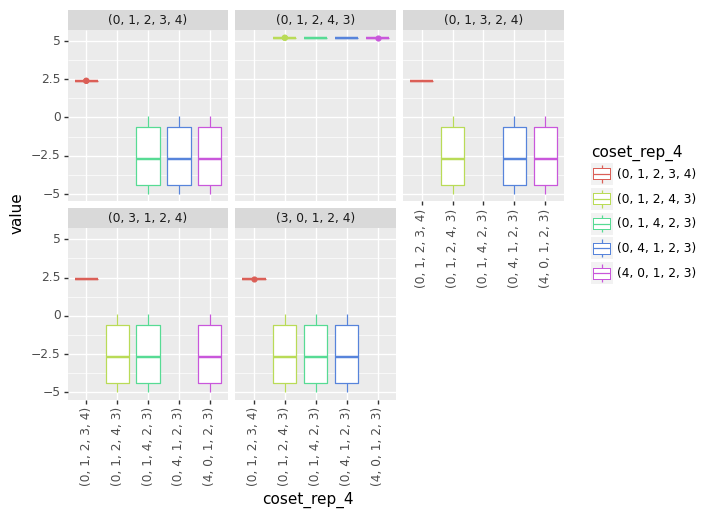

<ggplot: (684085723)>

In [20]:
from plotnine import geom_boxplot

col = 'dim16'
# 2
coset_1 = "coset_rep_4"
coset_2 = "coset_rep_3"
df = (
    llin_df.filter(pl.col('irrep') == "(2, 1, 1, 1)")
    .select(['permutation', col])
    .join(s4_df.select(['permutation', coset_1, coset_2]), left_on='permutation', right_on='permutation', how='inner')
    #.filter(pl.col(coset) == "(0, 1, 3, 4, 5, 2)")
    #.join(s4_df.select(['permutation', coset_left]), left_on='permutation_left', right_on='permutation', how='inner')
    .melt(id_vars=['permutation', coset_1, coset_2])
    #.filter(pl.col(coset) == "(0, 1, 3, 4, 5, 2)")
)

ggplot(df, aes(x=coset_1, y='value', color=coset_1)) + geom_boxplot() + facet_wrap(f'~{coset_2}') + theme(axis_text_x=element_text(rotation=90))

In [22]:

pos_name = '4th_position'
(llin_df
    .filter(pl.col('irrep') == "(2, 1, 1, 1)")
    .with_columns([pl.col('permutation').str.extract("([0-4])\)$").alias(pos_name)])
    .select(['permutation', pos_name, 'dim16'])
)


permutation,4th_position,dim16
str,str,f32
"""(0, 1, 2, 3, 4...","""4""",2.399756
"""(0, 1, 3, 4, 2...","""2""",-2.724102
"""(0, 1, 4, 2, 3...","""3""",5.219599
"""(0, 2, 1, 4, 3...","""3""",5.21881
"""(0, 2, 3, 1, 4...","""4""",2.400299
"""(0, 2, 4, 3, 1...","""1""",-4.983339
"""(0, 3, 1, 2, 4...","""4""",2.399559
"""(0, 3, 2, 4, 1...","""1""",-4.984022
"""(0, 3, 4, 1, 2...","""2""",-2.72274


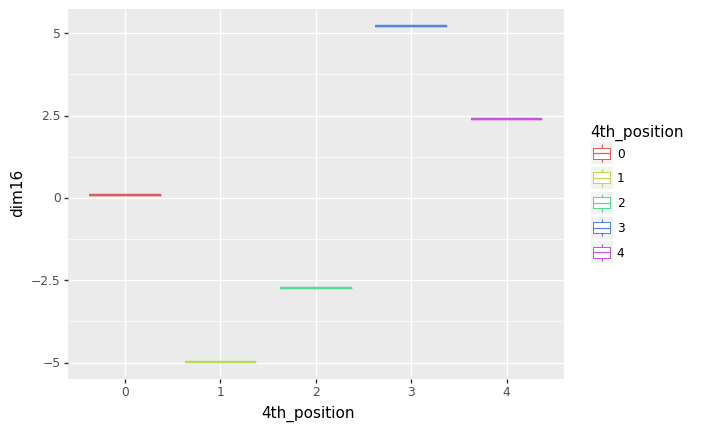

<ggplot: (702580878)>

In [23]:
col = 'dim16'
pos_name = '4th_position'
# 2

df = (
    llin_df
    .filter(pl.col('irrep') == "(2, 1, 1, 1)")
    .with_columns([pl.col('permutation').str.extract("([0-4])\)$").alias(pos_name)])
    .select(['permutation', pos_name, col])
    #.join(s4_df.select(['permutation', coset_1, coset_2]), left_on='permutation', right_on='permutation', how='inner')
    #.filter(pl.col(coset) == "(0, 1, 3, 4, 5, 2)")
    #.join(s4_df.select(['permutation', coset_left]), left_on='permutation_left', right_on='permutation', how='inner')
    #.melt(id_vars=['permutation', pos_name])
    #.filter(pl.col(coset) == "(0, 1, 3, 4, 5, 2)")
)

ggplot(df, aes(x=pos_name, y=col, color=pos_name)) + geom_boxplot()

In [24]:
rlin_fb = sn_fourier_basis(rlin_ft, 5)
rlin_df = fourier_basis_to_df(rlin_fb, 5)


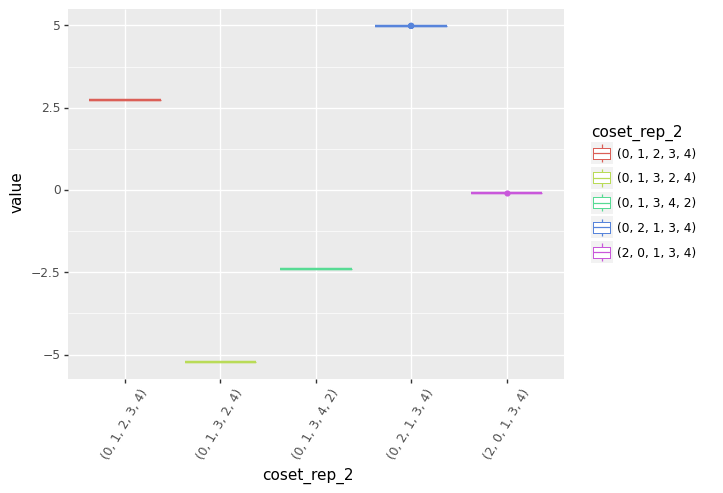

<ggplot: (702621967)>

In [25]:
col = 'dim16'
# 2
coset_1 = "coset_rep_2"
coset_2 = "coset_rep_3"
df = (
    rlin_df.filter(pl.col('irrep') == "(2, 1, 1, 1)")
    .select(['permutation', col])
    .join(s4_df.select(['permutation', coset_1, coset_2]), left_on='permutation', right_on='permutation', how='inner')
    #.filter(pl.col(coset) == "(0, 1, 3, 4, 5, 2)")
    #.join(s4_df.select(['permutation', coset_left]), left_on='permutation_left', right_on='permutation', how='inner')
    .melt(id_vars=['permutation', coset_1, coset_2])
    #.filter(pl.col(coset) == "(0, 1, 3, 4, 5, 2)")
)

ggplot(df, aes(x=coset_1, y='value', color=coset_1)) + geom_boxplot()  + theme(axis_text_x=element_text(rotation=60))

In [26]:
def get_index_of(col_name, element):
    return (
        pl.col(col_name)
        .arr.eval((pl.element() == element).cast(pl.UInt32))
        .arr.arg_max().cast(pl.Utf8)
    )


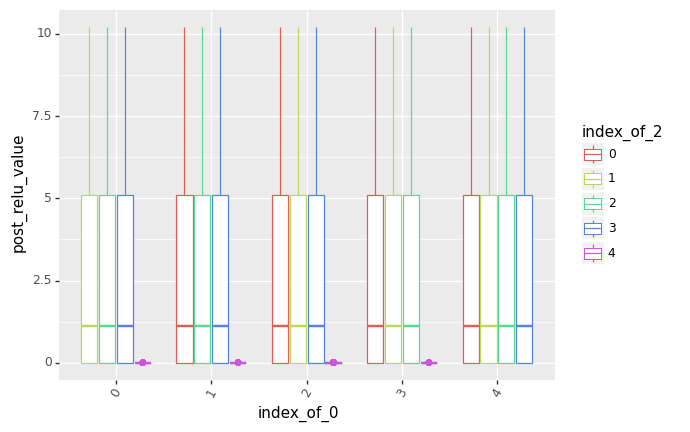

<ggplot: (702549335)>

In [27]:
col = 'dim16'
# 2
coset_1 = "coset_rep_2"
coset_2 = "coset_rep_3"
df = (
    linear_acts_df
    .select(['permutation_target', col])
    .with_columns([
        pl.col('permutation_target').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        pl.col(col).clip_min(0.0).alias('post_relu_value')
    ])
    #.select(['val_at_index_0', 'val_at_index_1', 'val_at_index_2', 'val_at_index_3', 'val_at_index_4', col])
)

ggplot(
    df,
    aes(x='index_of_0', y='post_relu_value', color='index_of_2')
) + geom_boxplot() + theme(axis_text_x=element_text(rotation=60))

In [28]:
(
    linear_acts_df
    .select(['permutation_target', col]).filter(pl.col(col) > 9)
    .groupby('permutation_target')
    .agg([
        pl.count(),
        pl.col('dim16').min().alias('min'),
        pl.col('dim16').mean().alias('mean'),
        pl.col('dim16').max().alias('max')
    ])
)

permutation_target,count,min,mean,max
str,u32,f32,f32,f32
"""(4, 2, 1, 3, 0...",6,10.201498,10.203681,10.204568
"""(0, 4, 1, 2, 3...",6,10.203904,10.204728,10.205658
"""(4, 2, 0, 3, 1...",6,10.201806,10.206599,10.209894
"""(1, 4, 3, 2, 0...",6,10.198228,10.204406,10.207897
"""(2, 0, 1, 4, 3...",6,10.199787,10.204238,10.206982
"""(2, 0, 1, 3, 4...",6,10.202352,10.204307,10.206717
"""(2, 3, 0, 4, 1...",6,10.204466,10.206833,10.213075
"""(2, 3, 1, 0, 4...",6,10.198718,10.204307,10.206875
"""(3, 4, 0, 2, 1...",6,10.204146,10.207324,10.21194


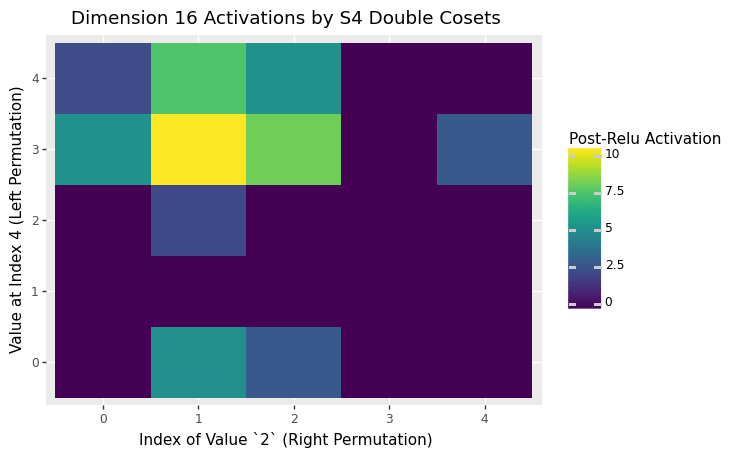

<ggplot: (702628357)>

In [30]:
from plotnine import ggtitle, labs

col = 'dim16'

#df = (
#    linear_acts_df
#    .select(['permutation_left', 'permutation_right', 'permutation_target', col])
#)

#ggplot(df, aes(x=col)) + geom_histogram(binwidth=0.5)


df = (
    linear_acts_df
    .with_columns([
        pl.col('permutation_left').str.extract_all('([0-4])').alias('left_vals'),
        pl.col('permutation_right').str.extract_all('([0-4])').alias('right_vals'),
        pl.col('permutation_target').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
         pl.col('left_vals').arr.get(4).alias('left_perm_value_at_index_4'),
         pl.col('right_vals').arr.eval((pl.element() == '2').cast(pl.UInt32)).arr.arg_max().cast(pl.Utf8).alias('right_perm_index_of_value_2') 
    ])
    .select(['left_perm_value_at_index_4', 'right_perm_index_of_value_2', col])
    #.rename({col: 'value'})
    .with_columns(pl.col(col).clip_min(0.0).alias('Post-Relu Activation'))
)




(
    ggplot(
        df,
        aes(x='right_perm_index_of_value_2', y ='left_perm_value_at_index_4', fill='Post-Relu Activation')
    ) 
    + geom_tile()
    + labs(x='Index of Value `2` (Right Permutation)', y='Value at Index 4 (Left Permutation)')
    + ggtitle('Dimension 16 Activations by S4 Double Cosets')
)


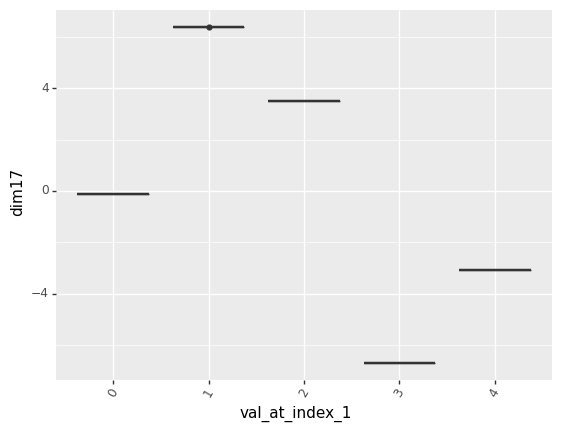

<ggplot: (702942833)>

In [31]:
col = 'dim17'
# 2

df = (
    llin_df
    .filter(pl.col('irrep') == '(2, 1, 1, 1)')
    .select(['permutation', col])
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('perm_vals'),
    ])
    .with_columns([
        pl.col('perm_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('perm_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('perm_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('perm_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('perm_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('perm_vals', '0').alias('index_of_0'),
        get_index_of('perm_vals', '1').alias('index_of_1'),
        get_index_of('perm_vals', '2').alias('index_of_2'),
        get_index_of('perm_vals', '3').alias('index_of_3'),
        get_index_of('perm_vals', '4').alias('index_of_4'),
        #pl.col(col).clip_min(0.0).alias('post_relu_value')
    ])
    #.select(['val_at_index_0', 'val_at_index_1', 'val_at_index_2', 'val_at_index_3', 'val_at_index_4', col])
)

ggplot(
    df,
    aes(x='val_at_index_1', y='dim17')
) + geom_boxplot() + theme(axis_text_x=element_text(rotation=60))

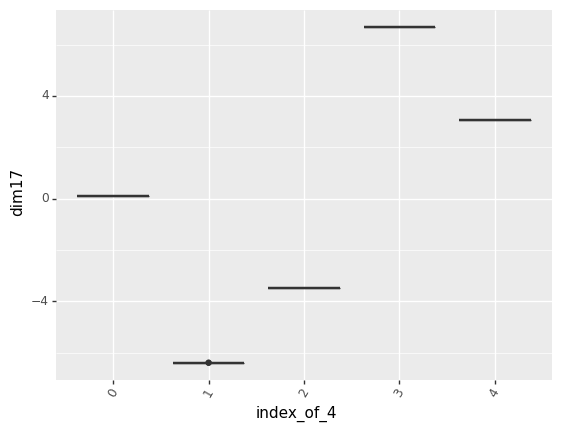

<ggplot: (703184332)>

In [32]:
col = 'dim17'
# 2

df = (
    rlin_df
    .filter(pl.col('irrep') == '(2, 1, 1, 1)')
    .select(['permutation', col])
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('perm_vals'),
    ])
    .with_columns([
        pl.col('perm_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('perm_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('perm_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('perm_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('perm_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('perm_vals', '0').alias('index_of_0'),
        get_index_of('perm_vals', '1').alias('index_of_1'),
        get_index_of('perm_vals', '2').alias('index_of_2'),
        get_index_of('perm_vals', '3').alias('index_of_3'),
        get_index_of('perm_vals', '4').alias('index_of_4'),
        #pl.col(col).clip_min(0.0).alias('post_relu_value')
    ])
    #.select(['val_at_index_0', 'val_at_index_1', 'val_at_index_2', 'val_at_index_3', 'val_at_index_4', col])
)

ggplot(
    df,
    aes(x='index_of_4', y='dim17')
) + geom_boxplot() + theme(axis_text_x=element_text(rotation=60))

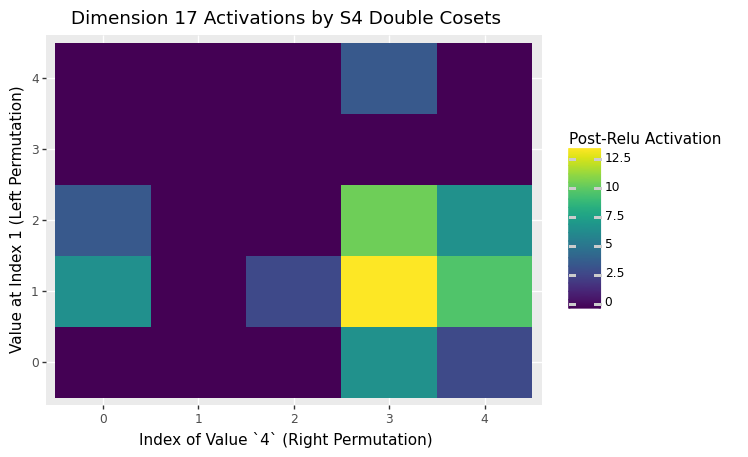

<ggplot: (704005358)>

In [33]:
col = 'dim17'

#df = (
#    linear_acts_df
#    .select(['permutation_left', 'permutation_right', 'permutation_target', col])
#)

#ggplot(df, aes(x=col)) + geom_histogram(binwidth=0.5)


df = (
    linear_acts_df
    .with_columns([
        pl.col('permutation_left').str.extract_all('([0-4])').alias('left_vals'),
        pl.col('permutation_right').str.extract_all('([0-4])').alias('right_vals'),
        pl.col('permutation_target').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('left_vals').arr.get(1).alias('left_perm_value_at_index_1'),
        get_index_of('right_vals', '4').alias('right_perm_index_of_value_4')
    ])
    .select(['left_perm_value_at_index_1', 'right_perm_index_of_value_4', col])
    #.rename({col: 'value'})
    .with_columns(pl.col(col).clip_min(0.0).alias('Post-Relu Activation'))
)




(
    ggplot(
        df,
        aes(x='right_perm_index_of_value_4', y ='left_perm_value_at_index_1', fill='Post-Relu Activation')
    ) 
    + geom_tile()
    + labs(x='Index of Value `4` (Right Permutation)', y='Value at Index 1 (Left Permutation)')
    + ggtitle('Dimension 17 Activations by S4 Double Cosets')
)


In [34]:
cols2111 = (
    llin_df
    .filter(pl.col('irrep') == "(2, 1, 1, 1)")
    .select(pl.all().exclude('irrep')).melt(id_vars='permutation')
    .groupby('variable')
    .agg([
        pl.col('value').abs().mean()
    ])
    .sort('value')
    .tail(33)
)['variable'].to_list()




In [48]:
cols2111

['dim80',
 'dim101',
 'dim58',
 'dim76',
 'dim12',
 'dim100',
 'dim16',
 'dim56',
 'dim65',
 'dim57',
 'dim45',
 'dim121',
 'dim54',
 'dim55',
 'dim90',
 'dim47',
 'dim41',
 'dim103',
 'dim106',
 'dim33',
 'dim27',
 'dim97',
 'dim94',
 'dim31',
 'dim89',
 'dim17',
 'dim93',
 'dim38',
 'dim77',
 'dim44',
 'dim24',
 'dim112',
 'dim110']

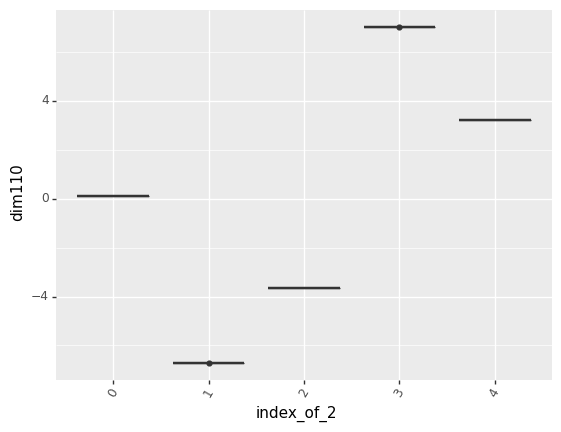

<ggplot: (703971809)>

In [47]:
col = 'dim110'
# 2

df = (
    rlin_df
    .filter(pl.col('irrep') == '(2, 1, 1, 1)')
    .select(['permutation', col])
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('perm_vals'),
    ])
    .with_columns([
        pl.col('perm_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('perm_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('perm_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('perm_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('perm_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('perm_vals', '0').alias('index_of_0'),
        get_index_of('perm_vals', '1').alias('index_of_1'),
        get_index_of('perm_vals', '2').alias('index_of_2'),
        get_index_of('perm_vals', '3').alias('index_of_3'),
        get_index_of('perm_vals', '4').alias('index_of_4'),
        #pl.col(col).clip_min(0.0).alias('post_relu_value')
    ])
    #.select(['val_at_index_0', 'val_at_index_1', 'val_at_index_2', 'val_at_index_3', 'val_at_index_4', col])
)

ggplot(
    df,
    aes(x='index_of_2', y=col)
) + geom_boxplot() + theme(axis_text_x=element_text(rotation=60))

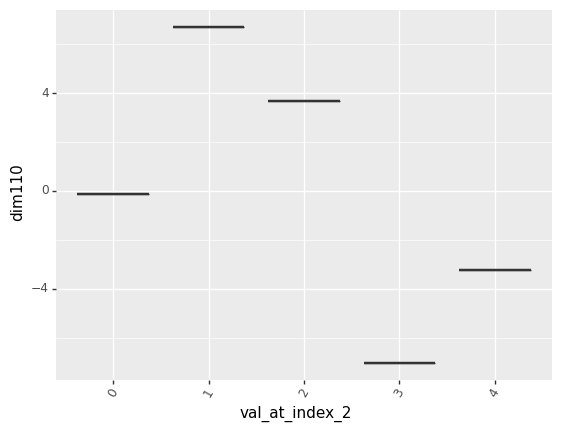

<ggplot: (704792279)>

In [43]:
col = 'dim110'
# 2

df = (
    llin_df
    .filter(pl.col('irrep') == '(2, 1, 1, 1)')
    .select(['permutation', col])
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('perm_vals'),
    ])
    .with_columns([
        pl.col('perm_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('perm_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('perm_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('perm_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('perm_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('perm_vals', '0').alias('index_of_0'),
        get_index_of('perm_vals', '1').alias('index_of_1'),
        get_index_of('perm_vals', '2').alias('index_of_2'),
        get_index_of('perm_vals', '3').alias('index_of_3'),
        get_index_of('perm_vals', '4').alias('index_of_4'),
        #pl.col(col).clip_min(0.0).alias('post_relu_value')
    ])
    #.select(['val_at_index_0', 'val_at_index_1', 'val_at_index_2', 'val_at_index_3', 'val_at_index_4', col])
)

ggplot(
    df,
    aes(x='val_at_index_2', y=col)
) + geom_boxplot() + theme(axis_text_x=element_text(rotation=60))

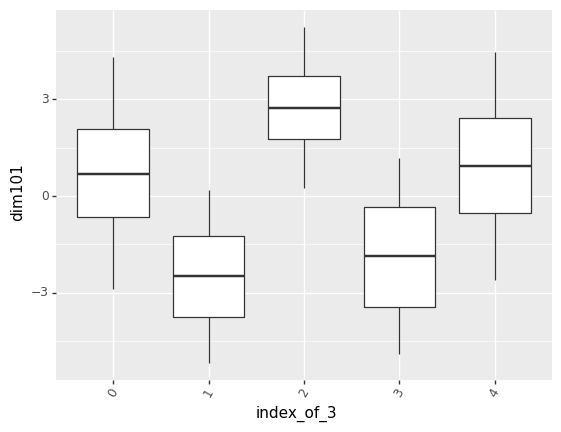

<ggplot: (705646265)>

In [98]:
col = 'dim101'
# 2

df = (
    llin_df
    .filter(pl.col('irrep') == '(2, 1, 1, 1)')
    .select(['permutation', col])
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('perm_vals'),
    ])
    .with_columns([
        pl.col('perm_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('perm_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('perm_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('perm_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('perm_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('perm_vals', '0').alias('index_of_0'),
        get_index_of('perm_vals', '1').alias('index_of_1'),
        get_index_of('perm_vals', '2').alias('index_of_2'),
        get_index_of('perm_vals', '3').alias('index_of_3'),
        get_index_of('perm_vals', '4').alias('index_of_4'),
        #pl.col(col).clip_min(0.0).alias('post_relu_value')
    ])
    #.select(['val_at_index_0', 'val_at_index_1', 'val_at_index_2', 'val_at_index_3', 'val_at_index_4', col])
)

ggplot(
    df,
    aes(x='index_of_3', y=col)
) + geom_boxplot() + theme(axis_text_x=element_text(rotation=60))

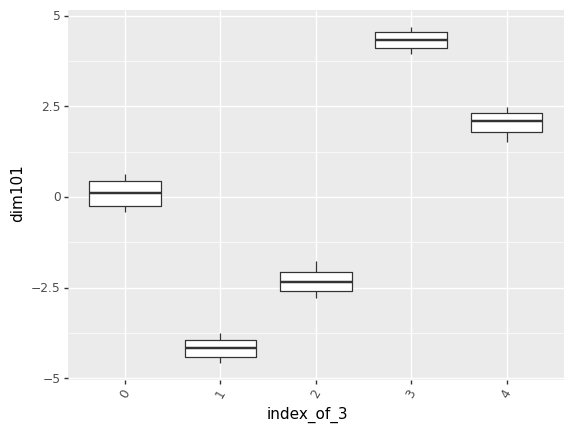

<ggplot: (705041703)>

In [102]:
col = 'dim101'
# 101 did not _quite_ converge?
# 2

df = (
    rlin_df
    .filter(pl.col('irrep') == '(2, 1, 1, 1)')
    .select(['permutation', col])
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('perm_vals'),
    ])
    .with_columns([
        pl.col('perm_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('perm_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('perm_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('perm_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('perm_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('perm_vals', '0').alias('index_of_0'),
        get_index_of('perm_vals', '1').alias('index_of_1'),
        get_index_of('perm_vals', '2').alias('index_of_2'),
        get_index_of('perm_vals', '3').alias('index_of_3'),
        get_index_of('perm_vals', '4').alias('index_of_4'),
        #pl.col(col).clip_min(0.0).alias('post_relu_value')
    ])
    #.select(['val_at_index_0', 'val_at_index_1', 'val_at_index_2', 'val_at_index_3', 'val_at_index_4', col])
)

ggplot(
    df,
    aes(x='index_of_3', y=col)
) + geom_boxplot() + theme(axis_text_x=element_text(rotation=60))

In [63]:
three_index = df.groupby('index_of_0').agg([pl.count(), pl.col(col).mean().alias('mean'), pl.col(col).var().alias('var')])

permutation,dim112,perm_vals,val_at_index_0,val_at_index_1,val_at_index_2,val_at_index_3,val_at_index_4,index_of_0,index_of_1,index_of_2,index_of_3,index_of_4
str,f32,list[str],str,str,str,str,str,str,str,str,str,str
"""(0, 1, 2, 3, 4...",0.116833,"[""0"", ""1"", ... ""4""]","""0""","""1""","""2""","""3""","""4""","""0""","""1""","""2""","""3""","""4"""
"""(0, 1, 3, 4, 2...",0.116149,"[""0"", ""1"", ... ""2""]","""0""","""1""","""3""","""4""","""2""","""0""","""1""","""4""","""2""","""3"""
"""(0, 1, 4, 2, 3...",0.116143,"[""0"", ""1"", ... ""3""]","""0""","""1""","""4""","""2""","""3""","""0""","""1""","""3""","""4""","""2"""
"""(0, 2, 1, 4, 3...",0.116164,"[""0"", ""2"", ... ""3""]","""0""","""2""","""1""","""4""","""3""","""0""","""2""","""1""","""4""","""3"""
"""(0, 2, 3, 1, 4...",0.116355,"[""0"", ""2"", ... ""4""]","""0""","""2""","""3""","""1""","""4""","""0""","""3""","""1""","""2""","""4"""
"""(0, 2, 4, 3, 1...",0.11618,"[""0"", ""2"", ... ""1""]","""0""","""2""","""4""","""3""","""1""","""0""","""4""","""1""","""3""","""2"""
"""(0, 3, 1, 2, 4...",0.117102,"[""0"", ""3"", ... ""4""]","""0""","""3""","""1""","""2""","""4""","""0""","""2""","""3""","""1""","""4"""
"""(0, 3, 2, 4, 1...",0.116785,"[""0"", ""3"", ... ""1""]","""0""","""3""","""2""","""4""","""1""","""0""","""4""","""2""","""1""","""3"""
"""(0, 3, 4, 1, 2...",0.116957,"[""0"", ""3"", ... ""2""]","""0""","""3""","""4""","""1""","""2""","""0""","""3""","""4""","""1""","""2"""


In [79]:

def position_df(data, column):
    df = (
        data
        .filter(pl.col('irrep') == '(2, 1, 1, 1)')
        .select(['permutation', column])
        .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('perm_vals'),
        ])
        .with_columns([
            pl.col('perm_vals').arr.get(0).alias('value_at_index_0'),
            pl.col('perm_vals').arr.get(1).alias('value_at_index_1'),
            pl.col('perm_vals').arr.get(2).alias('value_at_index_2'),
            pl.col('perm_vals').arr.get(3).alias('value_at_index_3'),
            pl.col('perm_vals').arr.get(4).alias('value_at_index_4'),
            get_index_of('perm_vals', '0').alias('index_of_0'),
            get_index_of('perm_vals', '1').alias('index_of_1'),
            get_index_of('perm_vals', '2').alias('index_of_2'),
            get_index_of('perm_vals', '3').alias('index_of_3'),
            get_index_of('perm_vals', '4').alias('index_of_4'),
            #pl.col(col).clip_min(0.0).alias('post_relu_value')
        ])
    )
    return df


def s4_analysis(left_acts, right_acts, columns):
    left_coset_names = [f'index_of_{i}' for i in range(5)]
    right_coset_names = [f'value_at_index_{i}' for i in range(5)]
    coset_names = left_coset_names + right_coset_names
    coset_data = []
    for colname in columns:
        left_position_df = position_df(left_acts, colname)
        right_position_df = position_df(right_acts, colname)
        left_total_vars = []
        left_mean_dists = []
        right_total_vars = []
        right_mean_dists = []
        for coset in coset_names:
            #print(coset)
            #print(left_position_df.columns)
            ldf = left_position_df.groupby(coset).agg([pl.col(colname).mean().alias('mean'), pl.col(colname).var().alias('var')])
            rdf = right_position_df.groupby(coset).agg([pl.col(colname).mean().alias('mean'), pl.col(colname).var().alias('var')])
            left_total_vars.append(ldf['var'].sum())
            right_total_vars.append(rdf['var'].sum())
            left_mean_dists.append(ldf['mean'].var())
            right_mean_dists.append(rdf['mean'].var())
        coldata = pl.DataFrame({
            'column': [colname] * len(coset_names),
            'cosets': coset_names,
            'left_total_vars': left_total_vars,
            'right_total_vara': right_total_vars,
            'left_mean_dists': left_mean_dists,
            'right_mean_dists': right_mean_dists
        })
        coset_data.append(coldata)
    return pl.concat(coset_data)
        
            
        

In [80]:
all_columns = s4_analysis(llin_df, rlin_df, cols2111)


In [83]:
coliter = (column for column in cols2111)

In [176]:
col = next(coliter)

StopIteration: 

In [186]:



left_indices = (
    all_columns
    .sort('left_total_vars')
    .groupby('column', maintain_order=True)
    .first()
    .with_columns(pl.col('cosets').str.slice(-1).alias('val_at_index'))
    .select(['column', 'val_at_index'])
)

In [189]:
right_indices = (
    all_columns
    .sort('right_total_vara')
    .groupby('column', maintain_order=True)
    .first()
    .with_columns(pl.col('cosets').str.slice(-1).alias('index_of'))
    .select(['column', 'index_of'])
)

In [190]:
full_effects = left_indices.join(right_indices, on='column', how='inner')

In [197]:
full_effects.sort(['val_at_index', 'index_of']).tail(24)

column,val_at_index,index_of
str,str,str
"""dim54""","""1""","""0"""
"""dim94""","""1""","""1"""
"""dim38""","""1""","""2"""
"""dim55""","""1""","""2"""
"""dim17""","""1""","""4"""
"""dim112""","""2""","""0"""
"""dim103""","""2""","""1"""
"""dim110""","""2""","""2"""
"""dim65""","""2""","""3"""


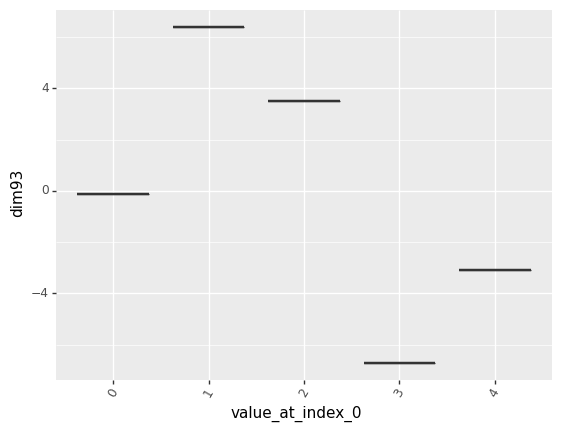

<ggplot: (706337886)>

In [212]:
col = 'dim93'

df = (
    llin_df
    .filter(pl.col('irrep') == '(2, 1, 1, 1)')
    .select(['permutation', col])
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('perm_vals'),
    ])
    .with_columns([
        pl.col('perm_vals').arr.get(0).alias('value_at_index_0'),
        pl.col('perm_vals').arr.get(1).alias('value_at_index_1'),
        pl.col('perm_vals').arr.get(2).alias('value_at_index_2'),
        pl.col('perm_vals').arr.get(3).alias('value_at_index_3'),
        pl.col('perm_vals').arr.get(4).alias('value_at_index_4'),
        get_index_of('perm_vals', '0').alias('index_of_0'),
        get_index_of('perm_vals', '1').alias('index_of_1'),
        get_index_of('perm_vals', '2').alias('index_of_2'),
        get_index_of('perm_vals', '3').alias('index_of_3'),
        get_index_of('perm_vals', '4').alias('index_of_4'),
        #pl.col(col).clip_min(0.0).alias('post_relu_value')
    ])
    #.select(['val_at_index_0', 'val_at_index_1', 'val_at_index_2', 'val_at_index_3', 'val_at_index_4', col])
)

ggplot(
    df,
    aes(x='value_at_index_0', y=col)
) + geom_boxplot() + theme(axis_text_x=element_text(rotation=60))

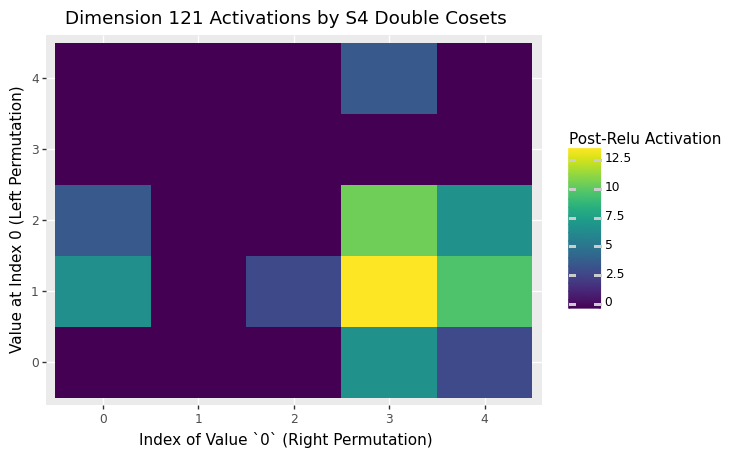

<ggplot: (703677176)>

In [163]:
col = 'dim93'

#df = (
#    linear_acts_df
#    .select(['permutation_left', 'permutation_right', 'permutation_target', col])
#)

#ggplot(df, aes(x=col)) + geom_histogram(binwidth=0.5)


df = (
    linear_acts_df
    .with_columns([
        pl.col('permutation_left').str.extract_all('([0-4])').alias('left_vals'),
        pl.col('permutation_right').str.extract_all('([0-4])').alias('right_vals'),
        pl.col('permutation_target').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('left_vals').arr.get(0).alias('left_perm_value_at_index_0'),
        get_index_of('right_vals', '0').alias('right_perm_index_of_value_0')
    ])
    .select(['left_perm_value_at_index_0', 'right_perm_index_of_value_0', col])
    #.rename({col: 'value'})
    .with_columns(pl.col(col).clip_min(0.0).alias('Post-Relu Activation'))
)




(
    ggplot(
        df,
        aes(x='right_perm_index_of_value_0', y ='left_perm_value_at_index_0', fill='Post-Relu Activation')
    ) 
    + geom_tile()
    + labs(x='Index of Value `0` (Right Permutation)', y='Value at Index 0 (Left Permutation)')
    + ggtitle('Dimension 121 Activations by S4 Double Cosets')
)


In [35]:

def get_double_cosets(subgroup1, subgroup2, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms1 = [Permutation(s) for s in subgroup1]
    perms2 = [Permutation(s) for s in subgroup2]
    group_elements = {}
    cosets = set()
    for g in Sn:
        coset = tuple(set(sorted([(s * g * t).sigma for s, t in product(perms1, perms2)])))
        if len(coset) in group_elements:
            group_elements[len(coset)].append(g.sigma)
        else:
            group_elements[len(coset)] = [g.sigma]
        cosets.add(coset)
    return sorted(list(cosets), key=lambda x: len(x)), group_elements



fixes0 = generate_subgroup(s4_subgroups['generators'][0])
fixes1 = generate_subgroup(s4_subgroups['generators'][1])
fixes2 = generate_subgroup(s4_subgroups['generators'][2])
fixes3 = generate_subgroup(s4_subgroups['generators'][3])
fixes4 = generate_subgroup(s4_subgroups['generators'][4])



['dim80',
 'dim101',
 'dim58',
 'dim76',
 'dim12',
 'dim100',
 'dim16',
 'dim56',
 'dim65',
 'dim57',
 'dim45',
 'dim121',
 'dim54',
 'dim55',
 'dim90',
 'dim47',
 'dim41',
 'dim103',
 'dim106',
 'dim33',
 'dim27',
 'dim97',
 'dim94',
 'dim31',
 'dim89',
 'dim17',
 'dim93',
 'dim38',
 'dim77',
 'dim44',
 'dim24',
 'dim112',
 'dim110']

In [ ]:
doubles, _ = get_double_cosets(fixes4, fixes1, 5)
doubles

In [ ]:
S5 = Permutation.full_group(5)
all_s5 = set([s.sigma for s in S5])

In [ ]:
frob = [Permutation(s) for s in f1]


In [ ]:
generate_subgroup(s3_x_s2["generators"][2])

In [ ]:
f2_cosets = get_cosets(generate_subgroup(frobenius_groups['generators'][2]))

In [231]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    tensor_dim = tensor.shape[1]
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(tensor_dim)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def embedding_harmonic_analysis(checkpoint):
    #run = torch.load(checkpoint, map_location=torch.device('cpu'))
    model = SnMLP.from_config(checkpoint['config'])
    model.load_state_dict(checkpoint['model'])
    epoch = checkpoint['checkpoint_epochs'][-1]
    
    #out, cache = model.run_with_cache(lperms[test_mask], rperms[test_mask])
    #loss = loss_fn(out, targets[test_mask])
    
    lembed_power_df, lembed_fourier_transform = calc_power_contributions(
        model.lembed.weight, 5
    )
    lembed_power_df.insert_at_idx(0, pl.Series('layer', ['left_embed'] * lembed_power_df.shape[0]))
    rembed_power_df, rembed_fourier_transform = calc_power_contributions(
        model.rembed.weight, 5
    )
    rembed_power_df.insert_at_idx(0, pl.Series('layer', ['right_embed'] * lembed_power_df.shape[0]))
    epochs = pl.Series('epoch', [epoch] * lembed_power_df.shape[0])
    lembed_power_df.insert_at_idx(0, epochs)
    rembed_power_df.insert_at_idx(0, epochs)
    return pl.concat([lembed_power_df, rembed_power_df], how='vertical'), lembed_fourier_transform, rembed_fourier_transform

In [232]:
lpower_df, _ = calc_power_contributions(model.lembed.weight @ W[:, :256].T, 5)
rpower_df, _ = calc_power_contributions(model.rembed.weight @ W[:, 256:].T, 5)

In [243]:
lpower_df.head()

irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,dim35,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(1, 1, 1, 1, 1...",0.000004,0.000008,0.000002,0.000022,0.000002,0.000015,0.001107,0.000007,0.00002,0.000002,0.000002,0.000007,7.6016e-9,0.000014,0.000035,0.000003,1.6249e-8,6.7783e-10,0.000023,0.000003,0.000003,0.000022,0.000003,0.000012,9.8056e-10,0.000003,0.000003,1.5218e-8,0.000008,9.3786e-7,0.005436,2.7091e-9,0.002007,2.7021e-9,0.003593,0.000003,...,8.6517e-7,0.00001,1.3393e-8,8.2615e-10,0.000048,0.000004,1.3802e-8,0.000001,0.000036,9.8026e-9,0.000006,0.000003,1.8222e-8,0.00003,0.001031,1.0086e-8,0.000004,0.000027,0.000003,2.0620e-9,0.000008,3.5025e-10,0.000004,0.000002,0.002056,0.000003,0.000027,0.000027,0.000014,0.000012,3.5343e-9,0.000003,0.000473,0.000003,0.000004,0.000584,0.000002
"""(2, 1, 1, 1)""",0.000114,0.000024,1.9515e-8,0.000546,0.000425,0.00033,0.279968,0.000128,0.000432,1.8267e-7,1.2635e-7,0.000654,1.0,0.003242,0.00068,0.000023,1.0,1.0,0.002647,0.000107,0.001799,0.000094,1.7431e-8,0.001058,1.0,0.000962,2.9838e-8,1.0,0.008144,0.000209,0.200944,1.0,0.192523,1.0,0.122886,2.1112e-8,...,0.001773,0.000022,1.0,1.0,0.000125,0.004316,1.0,0.001093,0.000163,1.0,0.993193,0.000604,1.0,0.000731,0.06787,1.0,0.000321,0.000789,1.7733e-8,1.0,0.000117,1.0,0.000671,0.000594,0.103245,3.1956e-8,0.000225,0.000432,0.0001,0.000282,1.0,0.000797,0.071934,5.2032e-8,0.000199,0.050403,9.8517e-8
"""(2, 2, 1)""",0.000051,0.000037,2.8022e-8,0.0002,0.000589,0.000455,0.620514,0.000072,0.00014,4.2403e-7,2.5485e-7,0.000119,4.8751e-8,0.000132,0.000168,0.000017,4.3141e-8,7.7402e-9,0.000187,0.000134,0.00011,0.000082,2.3076e-8,0.000167,1.2659e-8,0.000384,4.3717e-8,1.5129e-8,0.000716,0.000139,0.640603,2.9548e-9,0.649701,2.7840e-9,0.804967,4.8230e-8,...,0.000135,0.000032,1.4687e-8,6.8927e-8,0.000089,0.00004,3.1637e-8,0.000148,0.000351,1.1617e-8,0.000212,0.000145,1.4487e-8,0.000213,0.845285,2.6375e-8,0.000548,0.000307,4.5978e-8,8.5402e-9,0.00022,1.5084e-8,0.000066,0.00013,0.82761,3.3409e-8,0.00013,0.000158,0.000114,0.000122,4.4462e-8,0.000166,0.864899,1.3884e-7,0.000589,0.832487,1.1906e-7
"""(3, 1, 1)""",0.000092,0.000053,4.9671e-8,0.000211,0.000908,0.000538,0.017485,0.000097,0.000261,5.7362e-7,3.4374e-7,0.000043,7.7063e-8,0.000239,0.000263,0.000017,3.4405e-8,1.6679e-8,0.000252,0.000239,0.000243,0.000173,4.7639e-8,0.000212,1.7295e-8,0.000203,5.8107e-8,2.0304e-8,0.000064,0.000188,0.019458,4.1132e-9,0.01474,5.2066e-9,0.022551,5.3791e-8,...,0.000187,0.000046,3.2513e-8,5.4736e-8,0.000411,0.000114,4.2914e-8,0.000212,0.000169,1.1077e-8,0.000035,0.000271,1.1068e-8,0.000268,0.020295,2.8450e-8,0.000775,0.000816,3.1271e-8,1.2137e-8,0.000212,2.4686e-8,0.000161,0.000266,0.015358,5.6617e-8,0.000264,0.000265,0.000235,0.000059,7.7754e-8,0.00027,0.011599,1.3316e-7,0.000761,0.013061,2.2850e-7
"""(3, 2)""",0.000076,0.999853,0.999998,0.000848,0.000972,0.000856,0.011248,0.000092,0.000222,0.999996,0.999996,0.997643,6.2924e-8,0.000274,0.00022,0.000018,4.3670e-8,6.2138e-9,0.000492,0.000317,0.000199,0.000242,0.999997,0.000534,1.2316e-8,0.012804,0.999997,1.6533e-8,0.983702,0.000117,0.019763,2.3168e-9,0.023107,2.3475e-9,0.016717,0.999996,...,0.000104,0.99987,1.5468e-8,3.1306e-8,0.000436,0.000085,2.0873e-8,0.000152,0.000513,9.3218e-9,0.003289,0.000399,8.5169e-9,0.000235,0.017214,1.9756e-8,0.000834,0.001128,0.999997,3.9423e-9

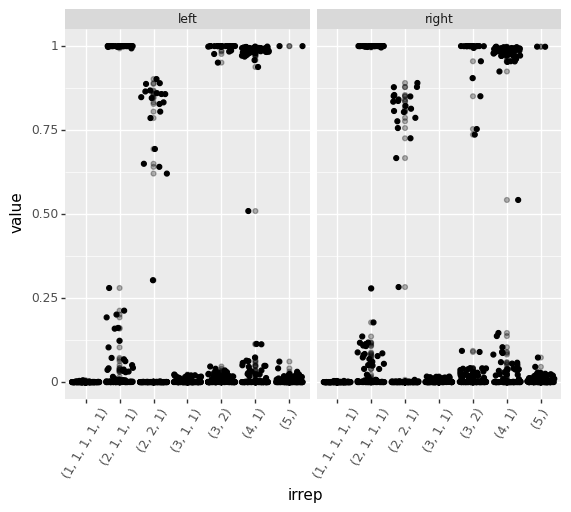

<ggplot: (354972498)>

In [251]:
from plotnine import geom_jitter

#lpower_df.insert_at_idx(0, pl.Series('layer', ['left'] * 7))
#rpower_df.insert_at_idx(0, pl.Series('layer', ['right'] * 7))

both_powers = pl.concat([lpower_df, rpower_df], how='vertical')

(
    ggplot(both_powers.melt(id_vars=['layer', 'irrep']), aes(x='irrep', y='value')) 
    + geom_point(alpha=0.3) 
    + geom_jitter()
    + theme(axis_text_x=element_text(rotation=60))
    + facet_wrap('~layer')
)

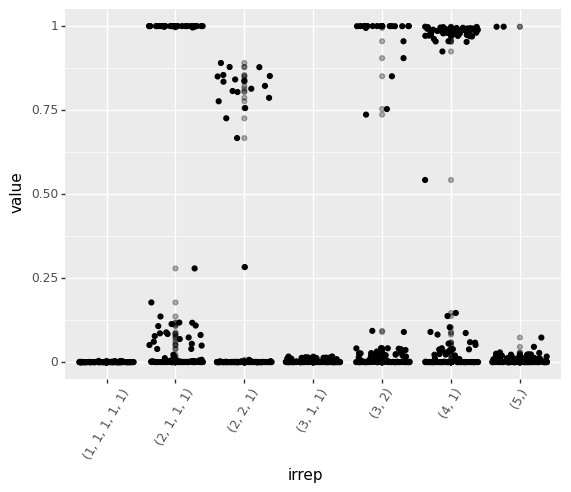

<ggplot: (354409064)>

In [242]:

(
    ggplot(rpower_df.melt(id_vars=['irrep']), aes(x='irrep', y='value')) 
    + geom_point(alpha=0.3) 
    + geom_jitter()
    + theme(axis_text_x=element_text(rotation=60))
)

In [244]:
power_df = lpower_df.melt(id_vars=['irrep']).join(rpower_df.melt(id_vars=['irrep']), on=['irrep', 'variable'], how='inner')

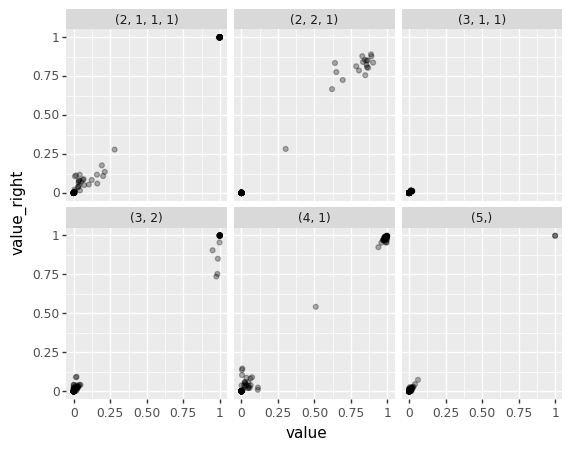

<ggplot: (354409049)>

In [247]:
ggplot(
    power_df.filter(pl.col('irrep') != "(1, 1, 1, 1, 1)"),
    aes(x='value', y='value_right')) + geom_point(alpha=0.3) + facet_wrap('~irrep')

In [253]:


embed_power_df, _, _ = embedding_harmonic_analysis(model_run)
embed_power_df.head()

epoch,layer,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,...,dim219,dim220,dim221,dim222,dim223,dim224,dim225,dim226,dim227,dim228,dim229,dim230,dim231,dim232,dim233,dim234,dim235,dim236,dim237,dim238,dim239,dim240,dim241,dim242,dim243,dim244,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255
i64,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
33440,"""left_embed""","""(1, 1, 1, 1, 1...",0.000036,0.000022,0.000237,0.000059,0.000057,0.000004,0.000026,0.000164,0.000004,0.000063,0.000071,0.000464,0.000702,0.000106,0.000007,0.000455,0.000138,0.000006,0.000017,0.000026,0.000094,0.000098,0.000007,1.7972e-8,0.000299,0.000119,0.000001,0.00002,0.000026,0.000014,0.000038,0.000002,0.000042,0.000052,...,0.000004,0.000055,0.00012,0.00004,0.000025,0.000201,0.0002,0.000039,6.6416e-7,0.000003,0.000122,0.000006,0.000037,0.000109,0.000017,0.000018,0.000091,0.000136,0.000017,0.000473,0.000549,0.00003,0.000275,0.000025,0.000009,0.000035,0.000016,0.00002,0.000084,0.000177,0.000083,0.000036,0.00021,0.000164,0.000008,0.000324,2.4562e-10
33440,"""left_embed""","""(2, 1, 1, 1)""",0.444375,0.426237,0.516266,0.490501,0.427651,0.371853,0.420859,0.40494,0.389425,0.331192,0.505219,0.416959,0.490191,0.484976,0.403937,0.3941,0.466429,0.394801,0.452802,0.439372,0.51008,0.560833,0.42684,0.444547,0.604391,0.414615,0.392683,0.519001,0.422232,0.482894,0.501608,0.360771,0.441153,0.421065,...,0.536831,0.531,0.543044,0.505912,0.404726,0.410562,0.456189,0.421803,0.435764,0.467759,0.483206,0.39459,0.496477,0.468626,0.427219,0.489816,0.505412,0.422796,0.273483,0.369222,0.487842,0.430325,0.423635,0.530341,0.261397,0.412578,0.502759,0.367088,0.469856,0.488224,0.529505,0.443223,0.352595,0.386027,0.451731,0.455546,0.464859
33440,"""left_embed""","""(2, 2, 1)""",0.007006,0.011908,0.010431,0.007581,0.013107,0.016437,0.009146,0.014561,0.010599,0.004889,0.016683,0.005939,0.009133,0.010679,0.015795,0.023392,0.006836,0.006866,0.009333,0.008918,0.015635,0.01038,0.012145,0.011917,0.018434,0.009262,0.024348,0.006388,0.016894,0.014267,0.012604,0.009222,0.00742,0.02982,...,0.021812,0.018278,0.010416,0.026275,0.011527,0.014037,0.005582,0.010759,0.006351,0.007726,0.016785,0.010476,0.006117,0.00853,0.0166,0.020602,0.016579,0.020247,0.014094,0.018392,0.024,0.028858,0.018624,0.01188,0.008644,0.010433,0.00439,0.015498,0.015252,0.013712,0.011105,0.012477,0.009632,0.015947,0.0162,0.014622,0.015613
33440,"""left_embed""","""(3, 1, 1)""",0.003447,0.004606,0.003927,0.004694,0.003314,0.00955,0.003252,0.004267,0.006698,0.002625,0.003639,0.004204,0.003391,0.005301,0.004992,0.00282,0.00273,0.004666,0.003245,0.005421,0.002668,0.003784,0.003829,0.005059,0.002186,0.004116,0.005139,0.004378,0.004599,0.007325,0.006134,0.003493,0.003495,0.00437,...,0.00405,0.00488,0.00397,0.004646,0.00405,0.001815,0.004718,0.004692,0.005022,0.003112,0.005685,0.002899,0.003829,0.004522,0.006725,0.004978,0.004552,0.003815,0.003137,0.006635,0.005217,0.003928,0.004228,0.003968,0.003269,0.003306,0.003478,0.003438,0.0028,0.004389,0.004049,0.003133,0.006019,0.00468,0.003957,0.004687,0.005898
33440,"""left_embed""","""(3, 2)""",0.09294,0.079224,0.089407,0.115774,0.073783,0.170436,0.102899,0.185678,0.178621,0.107854,0.103441,0.043979,0.077002,0.0542,0.142131,0.083457,0.096992,0.122215,0.057,0.099311,0.085183,0.065841,0.058479,0.133749,0.061296,0.151284,0.082923,0.091352,0.145323,0.090457,0.103458,0.115781,0.094102,0.139852,...,0.101593,0.044524,0.115324,0.055887,0.084722,0.124512,0.140631,0.138209,0.113084,0.130784,0.10363,0.128032,0.091419,0.056843,0.108941,0.13586,0.08984,0.083671,0.158103,0.079345,0.102915

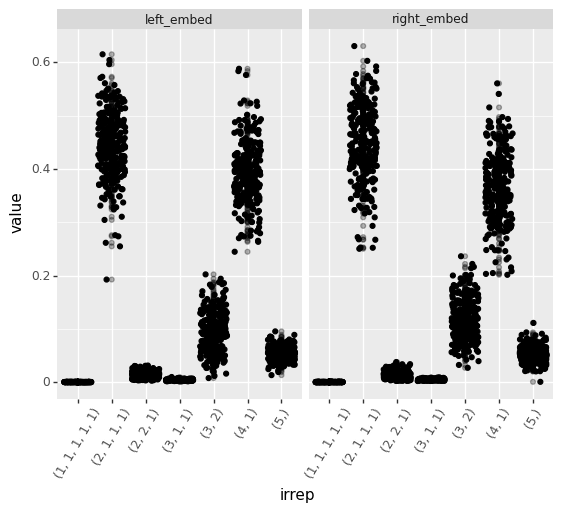

<ggplot: (703976283)>

In [254]:
(
    ggplot(embed_power_df.select(pl.all().exclude('epoch')).melt(id_vars=['layer', 'irrep']), aes(x='irrep', y='value')) 
    + geom_point(alpha=0.3) 
    + geom_jitter()
    + theme(axis_text_x=element_text(rotation=60))
    + facet_wrap('~layer')
)

In [256]:
both_powers.filter(pl.col('irrep') == "(4, 1)").melt(id_vars=['layer', 'irrep']).sort('value').tail(20)

layer,irrep,variable,value
str,str,str,f32
"""left""","""(4, 1)""","""dim8""",0.994129
"""left""","""(4, 1)""","""dim14""",0.994152
"""right""","""(4, 1)""","""dim87""",0.994254
"""left""","""(4, 1)""","""dim75""",0.994273
"""left""","""(4, 1)""","""dim53""",0.994325
"""left""","""(4, 1)""","""dim63""",0.994448
"""left""","""(4, 1)""","""dim50""",0.994533
"""right""","""(4, 1)""","""dim63""",0.994912
"""right""","""(4, 1)""","""dim4""",0.995681


In [326]:
col = 'dim78'
low_perms = (
    llin_df.filter(pl.col('irrep') == "(4, 1)")
    .select(['permutation', col])
    .filter(pl.col(col) < -2.0)
    .sort(col)['permutation']
    .to_list()
)
high_perms = (
    llin_df.filter(pl.col('irrep') == "(4, 1)")
    .select(['permutation', col])
    .filter(pl.col(col) > 2.0)
    .sort(col)['permutation']
    .to_list()
)

In [359]:
s3_x_s2 = {
    "order": 12,
    "copies": 10,
    "generators": [
        [(0, 1, 3, 4, 2), (0, 1, 3, 2, 4), (1, 0, 2, 3, 4)], #1
        [(0, 3, 2, 4, 1), (0, 1, 2, 4, 3), (2, 1, 0, 3, 4)], #2
        [(0, 2, 4, 3, 1), (0, 2, 1, 3, 4), (3, 1, 2, 0, 4)], #3
        [(0, 2, 3, 1, 4), (0, 2, 1, 3, 4), (4, 1, 2, 3, 0)], #4
        [(3, 1, 2, 4, 0), (3, 1, 2, 0, 4), (0, 2, 1, 3, 4)], #5
        [(2, 1, 4, 3, 0), (2, 1, 0, 3, 4), (0, 3, 2, 1, 4)], #6
        [(2, 1, 3, 0, 4), (2, 1, 0, 3, 4), (0, 4, 2, 3, 1)], #7
        [(1, 4, 2, 3, 0), (1, 0, 2, 3, 4), (0, 1, 3, 2, 4)], #8
        [(1, 3, 2, 0, 4), (1, 0, 2, 3, 4), (0, 1, 4, 3, 2)], #9
        [(1, 2, 0, 3, 4), (1, 0, 2, 3, 4), (0, 1, 2, 4, 3)], #10
    ]

}

a4_subgroups = {
        "order": 12,
        "copies": 5,
        "generators": [
            [(0, 2, 1, 4, 3), (0, 3, 1, 2, 4)], # 1 fix 0
            [(2, 1, 0, 4, 3), (0, 1, 4, 2, 3)], # 2 fix 1
            [(1, 0, 2, 4, 3), (3, 0, 2, 1, 4)], # 3 fix 2
            [(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)], # 4 fix 3
            [(1, 0, 3, 2, 4), (2, 0, 1, 3, 4)], # 5 fix 4

        ]
    }


generate_subgroup(a4_subgroups['generators'][3])

[(4, 1, 0, 3, 2),
 (1, 4, 2, 3, 0),
 (2, 1, 4, 3, 0),
 (4, 2, 1, 3, 0),
 (0, 2, 4, 3, 1),
 (0, 4, 1, 3, 2),
 (1, 0, 4, 3, 2),
 (1, 2, 0, 3, 4),
 (4, 0, 2, 3, 1),
 (0, 1, 2, 3, 4),
 (2, 4, 0, 3, 1),
 (2, 0, 1, 3, 4)]

In [342]:
for cos in list(get_right_cosets(generate_subgroup(s3_x_s2['generators'][8]), 5)):
    print(len(cos))

12
12
12
12
12
12
12
12
12
12


In [362]:
lperms = sorted([eval(p) for p in low_perms])
hperms = sorted([eval(p) for p in high_perms])
lperms3 = set([p for p in lperms if p[3] == 3])
lperms4 = set([p for p in lperms if p[3] == 4])
hperms3 = set([p for p in hperms if p[3] == 3])
hperms4 = set([p for p in hperms if p[3] == 4])

In [364]:
fixes0_even = generate_subgroup(a4_subgroups['generators'][0])
fixes1_even = generate_subgroup(a4_subgroups['generators'][1])
fixes2_even = generate_subgroup(a4_subgroups['generators'][2])
fixes3_even = generate_subgroup(a4_subgroups['generators'][3])
fixes4_even = generate_subgroup(a4_subgroups['generators'][4])

In [366]:
SnIrrep(5, (3, 1, 1)).basis

[|0|1|2|
 |3|
 |4|,
 |0|1|3|
 |2|
 |4|,
 |0|1|4|
 |2|
 |3|,
 |0|2|3|
 |1|
 |4|,
 |0|2|4|
 |1|
 |3|,
 |0|3|4|
 |1|
 |2|]

In [363]:

for generators in a4_subgroups['generators']:
    cosets = list(get_right_cosets(generate_subgroup(generators), 5))
    
    for i, cos in enumerate(cosets):
        if set(cos) == hperms3:
            print(generators)
            print(i)
            print('Three in third place')
        elif set(cos) == hperms4:
            print(generators)
            print(i)
            print('Four in third place')
            
        
                                    

[(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)]
5
Four in third place
[(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)]
7
Three in third place


In [ ]:
get

In [313]:
s5_2111 = SnIrrep(5, (2, 1, 1, 1)).matrix_representations()
s5_41 = SnIrrep(5, (4, 1)).matrix_representations()

In [321]:
total = np.zeros((4, 4))

for p_str in perms:
    p = eval(p_str)
    #if p[3] == 3:
    total += s5_41[p]
print(total)

[[-3.75000000e+00 -2.90473751e+00  1.11022302e-16 -2.22044605e-16]
 [-1.45236875e+01 -1.12500000e+01 -5.55111512e-17  5.55111512e-17]
 [-1.11022302e-16 -1.94289029e-16  5.55111512e-17 -4.99600361e-16]
 [-3.76123345e-17  3.28290399e-16 -1.11022302e-16  4.44089210e-16]]


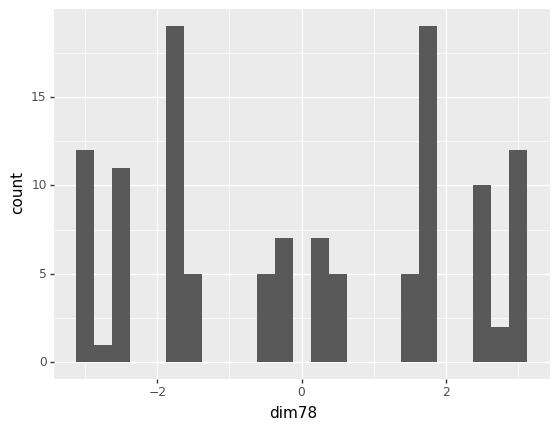

<ggplot: (352753547)>

In [262]:
col = 'dim78'


ggplot(llin_df.filter(pl.col('irrep') == "(4, 1)").select(['permutation', col]), aes(x=col)) + geom_histogram(binwidth=0.25)

In [ ]:
s2x

In [266]:



fixes01 = generate_subgroup(s3_subgroups['generators'][0])
fixes02 = generate_subgroup(s3_subgroups['generators'][1])
fixes03 = generate_subgroup(s3_subgroups['generators'][2])
fixes04 = generate_subgroup(s3_subgroups['generators'][3])
fixes12 = generate_subgroup(s3_subgroups['generators'][4])
fixes13 = generate_subgroup(s3_subgroups['generators'][5])
fixes14 = generate_subgroup(s3_subgroups['generators'][6])
fixes23 = generate_subgroup(s3_subgroups['generators'][7])
fixes24 = generate_subgroup(s3_subgroups['generators'][8])
fixes34 = generate_subgroup(s3_subgroups['generators'][9])

In [276]:
double_cosets, coset_map = get_double_cosets(fixes01, fixes23, 5)

In [373]:
for f in sorted(generate_subgroup(frobenius_groups['generators'][0])):
    perm = Permutation(f)
    print(f'{f}: order: {perm.order}, parity: {perm.parity}, conj class: {perm.conjugacy_class} ')

(0, 1, 2, 3, 4): order: 1, parity: 0, conj class: (1, 1, 1, 1, 1) 
(0, 2, 3, 4, 1): order: 4, parity: 1, conj class: (4, 1) 
(0, 3, 4, 1, 2): order: 2, parity: 0, conj class: (2, 2, 1) 
(0, 4, 1, 2, 3): order: 4, parity: 1, conj class: (4, 1) 
(1, 0, 3, 2, 4): order: 2, parity: 0, conj class: (2, 2, 1) 
(1, 2, 4, 0, 3): order: 5, parity: 0, conj class: (5,) 
(1, 3, 2, 4, 0): order: 4, parity: 1, conj class: (4, 1) 
(1, 4, 0, 3, 2): order: 4, parity: 1, conj class: (4, 1) 
(2, 0, 4, 3, 1): order: 4, parity: 1, conj class: (4, 1) 
(2, 1, 0, 4, 3): order: 2, parity: 0, conj class: (2, 2, 1) 
(2, 3, 1, 0, 4): order: 4, parity: 1, conj class: (4, 1) 
(2, 4, 3, 1, 0): order: 5, parity: 0, conj class: (5,) 
(3, 0, 1, 4, 2): order: 5, parity: 0, conj class: (5,) 
(3, 1, 4, 2, 0): order: 4, parity: 1, conj class: (4, 1) 
(3, 2, 0, 1, 4): order: 4, parity: 1, conj class: (4, 1) 
(3, 4, 2, 0, 1): order: 2, parity: 0, conj class: (2, 2, 1) 
(4, 0, 2, 1, 3): order: 4, parity: 1, conj class: (4, 1) 

In [382]:
[(Permutation((0, 2, 3, 4, 1))**i).sigma for i in range(4)]

[(0, 1, 2, 3, 4), (0, 2, 3, 4, 1), (0, 3, 4, 1, 2), (0, 4, 1, 2, 3)]

In [384]:
def get_left_frob_cosets(subgroup, frob_group):
    frob_group = [Permutation(f) for f in frob_group]
    all_frob = set([s.sigma for s in frob_group])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_frob:
        left = frob_group.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets





left_cosets = get_left_frob_cosets(
    [(Permutation((0, 2, 3, 4, 1))**i).sigma for i in range(4)],
    generate_subgroup(frobenius_groups['generators'][0])
)

    

In [395]:
left_cosets = get_left_cosets(generate_subgroup(frobenius_groups['generators'][0]), 5)

In [400]:
s5_2111 = SnIrrep(5, (2, 1, 1, 1)).matrix_representations()
s5_221 = SnIrrep(5, (2, 2, 1)).matrix_representations()
s5_32 = SnIrrep(5, (3, 2)).matrix_representations()

In [405]:
frob0 = sorted(generate_subgroup(frobenius_groups['generators'][0]))

In [475]:
s

(0, 3, 4, 1, 2)

In [497]:

perm = frob0[19]
print(f'{perm}, {Permutation(perm).order}')

(4, 3, 0, 2, 1), 5


In [469]:
s = Permutation(frob0[1]) ** 2
r = Permutation(frob0[19])



In [498]:
for perm in sorted(generate_subgroup([frob0[2], frob0[19]])):
    print(f'{perm}, {Permutation(perm).order}')

(0, 1, 2, 3, 4), 1
(0, 3, 4, 1, 2), 2
(1, 0, 3, 2, 4), 2
(1, 2, 4, 0, 3), 5
(2, 1, 0, 4, 3), 2
(2, 4, 3, 1, 0), 5
(3, 0, 1, 4, 2), 5
(3, 4, 2, 0, 1), 2
(4, 2, 1, 3, 0), 2
(4, 3, 0, 2, 1), 5


In [501]:
def get_frob_cosets(generators):
    frob_group = generate_subgroup(generators)
    full_frob = [Permutation(p) for p in frob_group]
    normal_sg = [p for p in full_frob if p.order == 5 or p.sigma == (0, 1, 2, 3, 4)]
    frob_group = set(frob_group)
    cosets = set()
    coset_reps = {}
    while union(cosets) != frob_group:
        left = full_frob.pop()
        coset = tuple(sorted([(left * s).sigma for s in normal_sg]))
        if coset not in cosets:
            coset_reps[left.sigma] = coset
            cosets.add(coset)
    return list(cosets), coset_reps
        

left_frob_cosets, coset_reps = get_frob_cosets(frobenius_groups['generators'][0])

In [502]:
coset_reps

{(1, 2, 4, 0, 3): ((0, 1, 2, 3, 4),
  (1, 2, 4, 0, 3),
  (2, 4, 3, 1, 0),
  (3, 0, 1, 4, 2),
  (4, 3, 0, 2, 1)),
 (0, 4, 1, 2, 3): ((0, 4, 1, 2, 3),
  (1, 3, 2, 4, 0),
  (2, 0, 4, 3, 1),
  (3, 2, 0, 1, 4),
  (4, 1, 3, 0, 2)),
 (3, 4, 2, 0, 1): ((0, 3, 4, 1, 2),
  (1, 0, 3, 2, 4),
  (2, 1, 0, 4, 3),
  (3, 4, 2, 0, 1),
  (4, 2, 1, 3, 0)),
 (4, 0, 2, 1, 3): ((0, 2, 3, 4, 1),
  (1, 4, 0, 3, 2),
  (2, 3, 1, 0, 4),
  (3, 1, 4, 2, 0),
  (4, 0, 2, 1, 3))}

In [533]:
np.flip(np.roots([1, 0, 0, 0, 0, -1]))

array([ 1.        +0.j        ,  0.30901699-0.95105652j,
        0.30901699+0.95105652j, -0.80901699-0.58778525j,
       -0.80901699+0.58778525j])

In [530]:
i = 1.0j
np.exp(0.4 * np.pi * i)

(0.30901699437494745+0.9510565162951535j)

In [534]:



five_cycle = [Permutation(p) for p in coset_reps[(1, 2, 4, 0, 3)]]

g_cosets = [g0, g1, g2, g3]
fifth_roots = np.flip(np.roots([1, 0, 0, 0, 0, -1]))

five_rep = {
    (0, 1, 2, 3, 4): fifth_roots[0],
    (0, 4, 1, 2, 3): fifth_roots[1],
    (0, 3, 4, 1, 2): fifth_roots[2],
    (0, 3, 4, 1, 2): fifth_roots[3]
}

In [546]:
five_cycle

[(0, 1, 2, 3, 4),
 (1, 2, 4, 0, 3),
 (2, 4, 3, 1, 0),
 (3, 0, 1, 4, 2),
 (4, 3, 0, 2, 1)]

In [541]:
np.concatenate(np.split(np.eye(4), 4, axis=1), axis=1)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [614]:
perm = Permutation((1, 2, 4, 0, 3))




def induced_rep(perm):
    perm = Permutation(perm)
    standard_basis = np.split(np.eye(4), 4, axis=1)
    g0 = Permutation((0, 1, 2, 3, 4))
    g1 = Permutation((0, 4, 1, 2, 3))
    g2 = Permutation((0, 3, 4, 1, 2))
    g3 = Permutation((0, 2, 3, 4, 1))
    coset_representatives = [g0, g1, g2, g3]
    gbasis = {g.sigma : v for g, v in zip(coset_representatives, standard_basis)}
    im = 1.0j
    fifth_roots = [np.exp(k * (2 / 5) * np.pi * im) for k in range(5)]
    five_cycle = [
        Permutation((0, 1, 2, 3, 4)),
        Permutation((1, 2, 4, 0, 3)), 
        Permutation((2, 4, 3, 1, 0)),
        Permutation((4, 3, 0, 2, 1)),
        Permutation((3, 0, 1, 4, 2))
    ]
    five_rep = {
        (0, 1, 2, 3, 4): fifth_roots[0],
        (1, 2, 4, 0, 3): fifth_roots[1],
        (2, 4, 3, 1, 0): fifth_roots[2],
        (4, 3, 0, 2, 1): fifth_roots[3],
        (3, 0, 1, 4, 2): fifth_roots[4]
    }
    perm_rep = []
    for cos_rep in g_cosets:
        prod = perm * cos_rep
        solutions = []
        for g, fiver in product(coset_representatives, five_cycle):
            gprod = g * fiver
            if gprod.sigma == prod.sigma:
                solutions.append(five_rep[fiver.sigma] * gbasis[g.sigma])
        if len(solutions) == 1:
            perm_rep.append(solutions[0])
        else:
            raise ValueError(f'Found {len(solutions)} for {perm} * {cos_rep} == {prod}')
    return np.concatenate(perm_rep, axis=1)
                


In [615]:
frob_ind = {f: induced_rep(f) for f in frob0}



In [619]:
Permutation((1, 2, 4, 0, 3)) ** 3

(4, 3, 0, 2, 1)

In [621]:
frob_ind[(1, 2, 4, 0, 3)] @ frob_ind[(1, 2, 4, 0, 3)] @ frob_ind[(1, 2, 4, 0, 3)]

array([[-0.80901699-0.58778525j,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.30901699-0.95105652j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.80901699+0.58778525j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.30901699+0.95105652j]])

In [620]:
frob_ind[(4, 3, 0, 2, 1)]

array([[-0.80901699-0.58778525j,  0.        +0.j        ,
        -0.        +0.j        ,  0.        +0.j        ],
       [ 0.        -0.j        ,  0.30901699-0.95105652j,
        -0.        +0.j        ,  0.        +0.j        ],
       [ 0.        -0.j        ,  0.        +0.j        ,
        -0.80901699+0.58778525j,  0.        +0.j        ],
       [ 0.        -0.j        ,  0.        +0.j        ,
        -0.        +0.j        ,  0.30901699+0.95105652j]])

In [635]:
for f1, f2 in product(frob0, frob0):
    if f1 == (0, 1, 2, 3, 4) or f2 == (0, 1, 2, 3, 4):
        continue
    perm1 = Permutation(f1)
    perm2 = Permutation(f2)
    permprod = perm1 * perm2
    matprod = np.real(frob_ind[f1] + np.conjugate(frob_ind[f1])) @ np.real(frob_ind[f2] + np.conjugate(frob_ind[f2]))
    prodmat = np.real(frob_ind[permprod.sigma] + np.conjugate(frob_ind[permprod.sigma]))
    assert np.allclose(matprod, prodmat), f'{perm1} * {perm2} != {permprod}'

AssertionError: (0, 2, 3, 4, 1) * (0, 2, 3, 4, 1) != (0, 3, 4, 1, 2)

In [623]:
total = 0.0
for f in frob0:
    perm = Permutation(f)
    prod = perm ** 2
    total += np.trace(frob_ind[prod.sigma])

total
    

(20-8.881784197001252e-16j)

In [625]:
total = 0.0
for f in frob0:
    total += np.imag(np.trace(frob_ind[f]))
print(total)
    

-8.881784197001252e-16


In [632]:
np.real(frob_ind[f] + np.conjugate(frob_ind[f]))

array([[-1.61803399,  0.        , -0.        ,  0.        ],
       [ 0.        ,  0.61803399, -0.        ,  0.        ],
       [ 0.        ,  0.        , -1.61803399,  0.        ],
       [ 0.        ,  0.        , -0.        ,  0.61803399]])

In [561]:
frob_ind[(1, 0, 3, 2, 4)] @ frob_ind[(1, 0, 3, 2, 4)]

array([[-0.80901699+0.58778525j,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.80901699-0.58778525j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.80901699+0.58778525j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , -0.80901699-0.58778525j]])

In [525]:
from itertools import product

for f in frob0:
    perm = Permutation(f)
    prod = perm * g1
    print(f'{perm} * {g1} == {perm * g1}')
    for g, fiver in product(g_cosets, five_cycle):
        gprod = g * fiver
        if gprod.sigma == prod.sigma:
            print(f'\t {g} * {fiver} == {gprod}')
    

(0, 1, 2, 3, 4) * (0, 4, 1, 2, 3) == (0, 4, 1, 2, 3)
	 (0, 4, 1, 2, 3) * (0, 1, 2, 3, 4) == (0, 4, 1, 2, 3)
(0, 2, 3, 4, 1) * (0, 4, 1, 2, 3) == (0, 1, 2, 3, 4)
	 (0, 1, 2, 3, 4) * (0, 1, 2, 3, 4) == (0, 1, 2, 3, 4)
(0, 3, 4, 1, 2) * (0, 4, 1, 2, 3) == (0, 2, 3, 4, 1)
	 (0, 2, 3, 4, 1) * (0, 1, 2, 3, 4) == (0, 2, 3, 4, 1)
(0, 4, 1, 2, 3) * (0, 4, 1, 2, 3) == (0, 3, 4, 1, 2)
	 (0, 3, 4, 1, 2) * (0, 1, 2, 3, 4) == (0, 3, 4, 1, 2)
(1, 0, 3, 2, 4) * (0, 4, 1, 2, 3) == (4, 0, 2, 1, 3)
	 (0, 2, 3, 4, 1) * (4, 3, 0, 2, 1) == (4, 0, 2, 1, 3)
(1, 2, 4, 0, 3) * (0, 4, 1, 2, 3) == (4, 1, 3, 0, 2)
	 (0, 4, 1, 2, 3) * (4, 3, 0, 2, 1) == (4, 1, 3, 0, 2)
(1, 3, 2, 4, 0) * (0, 4, 1, 2, 3) == (4, 2, 1, 3, 0)
	 (0, 3, 4, 1, 2) * (4, 3, 0, 2, 1) == (4, 2, 1, 3, 0)
(1, 4, 0, 3, 2) * (0, 4, 1, 2, 3) == (4, 3, 0, 2, 1)
	 (0, 1, 2, 3, 4) * (4, 3, 0, 2, 1) == (4, 3, 0, 2, 1)
(2, 0, 4, 3, 1) * (0, 4, 1, 2, 3) == (1, 0, 3, 2, 4)
	 (0, 3, 4, 1, 2) * (1, 2, 4, 0, 3) == (1, 0, 3, 2, 4)
(2, 1, 0, 4, 3) * (0, 4, 1, 

In [449]:
perm = frob0[19]
print(f'{perm}, {Permutation(perm).conjugacy_class}, {Permutation(perm).order}')
print(s5_32[perm])
print(np.trace(s5_32[perm]))

(4, 3, 0, 2, 1), (5,), 5
[[ 3.33333333e-01  2.35702260e-01 -4.08248290e-01 -4.08248290e-01
   7.07106781e-01]
 [-4.71404521e-01  4.16666667e-01 -7.21687836e-01  1.44337567e-01
  -2.50000000e-01]
 [ 8.16496581e-01  1.44337567e-01 -2.50000000e-01  2.50000000e-01
  -4.33012702e-01]
 [ 5.55111512e-17 -4.33012702e-01 -2.50000000e-01 -7.50000000e-01
  -4.33012702e-01]
 [ 0.00000000e+00 -7.50000000e-01 -4.33012702e-01  4.33012702e-01
   2.50000000e-01]]
-8.326672684688674e-17


In [458]:
s5_32[(4, 3, 0, 2, 1)] @ s5_32[(4, 3, 0, 2, 1)]

array([[-3.33333333e-01, -2.35702260e-01, -4.08248290e-01,
         4.08248290e-01,  7.07106781e-01],
       [-9.42809042e-01,  8.33333333e-02,  1.44337567e-01,
        -1.44337567e-01, -2.50000000e-01],
       [ 8.78454478e-18,  4.33012702e-01, -2.50000000e-01,
        -7.50000000e-01,  4.33012702e-01],
       [-2.40642739e-17,  4.33012702e-01,  7.50000000e-01,
         2.50000000e-01,  4.33012702e-01],
       [ 1.15906308e-16, -7.50000000e-01,  4.33012702e-01,
        -4.33012702e-01,  2.50000000e-01]])

In [461]:
five_cycle = [(Permutation((4, 3, 0, 2, 1))**i).sigma for i in range(5)]
total = np.zeros((5, 5))
for f in five_cycle:
    total += s5_221[f]

print(total)


[[ 2.00000000e+00  1.66533454e-16 -1.66533454e-16 -2.00000000e+00
  -1.41421356e+00]
 [ 1.66533454e-16  4.44089210e-16  2.22044605e-16 -1.11022302e-16
  -5.55111512e-17]
 [-1.66533454e-16  1.94289029e-16  4.44089210e-16  0.00000000e+00
  -3.88578059e-16]
 [-2.00000000e+00 -1.11022302e-16  0.00000000e+00  2.00000000e+00
   1.41421356e+00]
 [-1.41421356e+00 -7.58841233e-17 -4.44089210e-16  1.41421356e+00
   1.00000000e+00]]


In [445]:
for f in frob0:
    perm = f
    print(f'{perm}, {Permutation(perm).conjugacy_class}, {Permutation(perm).order}')
    print(s5_32[perm][0, 0])
    #print(np.trace(s5_32[perm]))

(0, 1, 2, 3, 4), (1, 1, 1, 1, 1), 1
1.0
(0, 2, 3, 4, 1), (4, 1), 4
0.33333333333333326
(0, 3, 4, 1, 2), (2, 2, 1), 2
0.3333333333333333
(0, 4, 1, 2, 3), (4, 1), 4
0.33333333333333326
(1, 0, 3, 2, 4), (2, 2, 1), 2
-0.3333333333333333
(1, 2, 4, 0, 3), (5,), 5
-0.33333333333333326
(1, 3, 2, 4, 0), (4, 1), 4
0.33333333333333315
(1, 4, 0, 3, 2), (4, 1), 4
0.33333333333333326
(2, 0, 4, 3, 1), (4, 1), 4
0.33333333333333326
(2, 1, 0, 4, 3), (2, 2, 1), 2
1.0
(2, 3, 1, 0, 4), (4, 1), 4
0.3333333333333332
(2, 4, 3, 1, 0), (5,), 5
0.33333333333333326
(3, 0, 1, 4, 2), (5,), 5
-0.33333333333333326
(3, 1, 4, 2, 0), (4, 1), 4
-0.33333333333333326
(3, 2, 0, 1, 4), (4, 1), 4
0.3333333333333332
(3, 4, 2, 0, 1), (2, 2, 1), 2
0.3333333333333332
(4, 0, 2, 1, 3), (4, 1), 4
0.33333333333333315
(4, 1, 3, 0, 2), (4, 1), 4
-0.33333333333333326
(4, 2, 1, 3, 0), (2, 2, 1), 2
-0.3333333333333332
(4, 3, 0, 2, 1), (5,), 5
0.33333333333333326


In [447]:
s5_32[(0, 1, 2, 4, 3)]

array([[-1.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.5      ,  0.8660254,  0.       ,  0.       ],
       [ 0.       ,  0.8660254, -0.5      ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.5      ,  0.8660254],
       [ 0.       ,  0.       ,  0.       ,  0.8660254, -0.5      ]])

In [448]:
s5_32[(2, 1, 0, 3, 4)]

array([[-1.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.5      ,  0.       , -0.8660254,  0.       ],
       [ 0.       ,  0.       ,  0.5      ,  0.       , -0.8660254],
       [ 0.       , -0.8660254,  0.       , -0.5      ,  0.       ],
       [ 0.       ,  0.       , -0.8660254,  0.       , -0.5      ]])

In [425]:
SnIrrep(5, (3, 2)).basis

[|0|1|2|
 |3|4|,
 |0|1|3|
 |2|4|,
 |0|1|4|
 |2|3|,
 |0|2|3|
 |1|4|,
 |0|2|4|
 |1|3|]

In [427]:
SnIrrep(5, (3, 1)).basis

[|0|1|2|
 |3|,
 |0|1|3|
 |2|,
 |0|2|3|
 |1|]

In [411]:
for cos in list(left_cosets):
    print(cos)
    total = np.zeros((5, 5))
    for perm in cos:
        total += s5_32[perm]
    print(total)
    print('#################')

((0, 1, 3, 4, 2), (0, 2, 4, 1, 3), (0, 3, 1, 2, 4), (0, 4, 2, 3, 1), (1, 0, 2, 4, 3), (1, 2, 0, 3, 4), (1, 3, 4, 0, 2), (1, 4, 3, 2, 0), (2, 0, 3, 1, 4), (2, 1, 4, 3, 0), (2, 3, 0, 4, 1), (2, 4, 1, 0, 3), (3, 0, 4, 2, 1), (3, 1, 2, 0, 4), (3, 2, 1, 4, 0), (3, 4, 0, 1, 2), (4, 0, 1, 3, 2), (4, 1, 0, 2, 3), (4, 2, 3, 0, 1), (4, 3, 2, 1, 0))
[[ 4.00000000e+00 -5.65685425e+00  4.44089210e-16  3.05260909e-16
   5.65685425e+00]
 [ 2.82842712e+00 -4.00000000e+00 -8.32667268e-16  0.00000000e+00
   4.00000000e+00]
 [ 4.89897949e+00 -6.92820323e+00  2.22044605e-16 -5.55111512e-17
   6.92820323e+00]
 [ 4.89897949e+00 -6.92820323e+00  6.38378239e-16  2.22044605e-16
   6.92820323e+00]
 [-2.82842712e+00  4.00000000e+00 -4.44089210e-16  3.33066907e-16
  -4.00000000e+00]]
#################
((0, 1, 4, 2, 3), (0, 2, 1, 3, 4), (0, 3, 2, 4, 1), (0, 4, 3, 1, 2), (1, 0, 4, 3, 2), (1, 2, 3, 4, 0), (1, 3, 0, 2, 4), (1, 4, 2, 0, 3), (2, 0, 1, 4, 3), (2, 1, 3, 0, 4), (2, 3, 4, 1, 0), (2, 4, 0, 3, 1), (3, 0, 2, 

In [ ]:

W = model.linear.weight
lperm = model.lembed.weight[0, :]
rperm = model.rembed.weight[1, :]
torch.allclose(W @ torch.concat([lperm, rperm]), cache['hook_linear'])

In [ ]:
2 ** 64

In [ ]:
W[:, :256] @ lperm

In [ ]:
torch.allclose((W[:, :256] @ model.lembed.weight.T)[:, 0], W[:, :256] @ lperm)

In [ ]:
llin_ft = slow_ft_1d(model.lembed.weight @ W[:, :256].T, 5)
rlin_ft = slow_ft_1d(model.rembed.weight @ W[:, 256:].T, 5)

In [ ]:
(model.lembed.weight @ W[:, :256].T)

In [ ]:
llin_ft[(1, 1, 1, 1, 1)].shape[0]

In [ ]:
def ft_to_block_diag(ft, index):
    blocks = []
    for k, mat in ft.items():
        dim = mat.shape[1] if mat.dim() > 1 else 1
        blocks.extend([mat[index] for _ in range(dim)])
    return torch.block_diag(*blocks)
        
ft_to_block_diag(llin_ft, 0)

In [ ]:
rlin_ft[(2, 1, 1, 1)][4] @ llin_ft[(2, 1, 1, 1)][4] 

In [ ]:
rlin_ft[(5,)].dim()

In [ ]:
from functorch import vmap


def ft_convolve(f, g):
    out = {}
    for key, m1 in f.items():
        m2 = g[key]
        if m1.dim() == 1:
            prod = m1 * m2
        else:
            prod = torch.bmm(m1, m2)
        out[key] = prod
    return out


sn_fourier_basis(ft_convolve(llin_ft, rlin_ft), 5)

In [ ]:

def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')

In [ ]:
convolved_fn = sn_fourier_basis(ft_convolve(llin_ft, rlin_ft), 5) / 120
conv_df = fourier_basis_to_df(convolved_fn, 5)

In [ ]:
convolved_fn.sum(dim=1)

In [ ]:
conv_df.head(7)

In [ ]:
from functools import reduce

def _coset_join(df1, df2):
    return df1.join(df2, on='permutation', how='inner')


def _coset_df(cosets, prefix):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), f'coset_rep_{prefix}': rep} for c in cos])
    return pl.DataFrame(data)



def make_coset_rep_df(generators):
    data = []
    
    for i, g in enumerate(generators):
        cosets = list(get_cosets(generate_subgroup(g)))
        data.append(_coset_df(cosets, i))
    
    return reduce(_coset_join, data)


#f2_cosets = get_cosets(generate_subgroup(frobenius_groups['generators'][2]))

#f1_df = make_coset_rep_df(list(f1_cosets))
#f2_df = make_coset_rep_df(list(f2_cosets))

frob_cosets = make_coset_rep_df(frobenius_groups['generators'])

In [ ]:


s3_cosets = make_coset_rep_df(s3_subgroups['generators'])
s4_cosets = make_coset_rep_df(s4_subgroups['generators'])
s3xs2_cosets = make_coset_rep_df(s3_x_s2['generators'])
a4_cosets = make_coset_rep_df(a4_subgroups['generators'])

In [ ]:
s3xs2_cosets.head()

In [ ]:
frob_analysis = (
    conv_df
    .join(frob_cosets, on='permutation', how='inner')
    .melt(id_vars=['permutation', 'coset_rep_0', 'coset_rep_1', 'coset_rep_2', 'coset_rep_3', 'coset_rep_4', 'coset_rep_5', 'irrep'])
)
frob_analysis.head()

s4_analysis = (
    conv_df
    .join(s4_cosets, on='permutation', how='inner')
    .melt(id_vars=['permutation', 'coset_rep_0', 'coset_rep_1', 'coset_rep_2', 'coset_rep_3', 'coset_rep_4', 'irrep'])
)

a4_analysis = (
    conv_df
    .join(a4_cosets, on='permutation', how='inner')
    .melt(id_vars=['permutation', 'coset_rep_0', 'coset_rep_1', 'coset_rep_2', 'coset_rep_3', 'coset_rep_4', 'irrep'])
)

s3_analysis = (
    conv_df
    .join(s3_cosets, on='permutation', how='inner')
    .melt(id_vars=[
        'permutation', 
        'coset_rep_0',
        'coset_rep_1',
        'coset_rep_2',
        'coset_rep_3',
        'coset_rep_4',
        'coset_rep_5',
        'coset_rep_6', 
        'coset_rep_7',
        'coset_rep_8',
        'coset_rep_9',
        'irrep'])
)

s3xs2_analysis = (
    conv_df
    .join(s3xs2_cosets, on='permutation', how='inner')
    .melt(id_vars=[
        'permutation', 
        'coset_rep_0',
        'coset_rep_1',
        'coset_rep_2',
        'coset_rep_3',
        'coset_rep_4',
        'coset_rep_5',
        'coset_rep_6', 
        'coset_rep_7',
        'coset_rep_8',
        'coset_rep_9',
        'irrep'])
)

In [ ]:
dim0_df = (
    linear_acts_df
    .select(pl.all().exclude('in_train'))
    .select(pl.all().exclude('^index.*$'))
    #.join(frob_cosets.melt(id_vars='permutation', variable_name='coset', value_name='coset_rep'), left_on='permutation_target', right_on='permutation' , how='inner')
    .melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target'])
    .filter(pl.col('variable') == 'dim0')
    #.select(pl.all().exclude('variable'))
    #.filter(pl.col('value') >= 0)
    #.with_columns((pl.col('value') * (pl.col('value') > 0.).cast(pl.Float32)).alias('relu_value'))
    #.groupby('permutation_target')
    #.agg([
    #    pl.col('value').min().alias('min_value'),
    #    pl.col('value').mean().alias('mean_value'),
    #    pl.col('value').std().alias('std_value'),
    #    pl.col('value').max().alias('max_value')
    #
    #])
    #.filter(pl.col('value').abs() > 8.5)
    .sort(['permutation_target', 'permutation_left', 'permutation_right', 'value'])
)
dim0_df.head(20)

In [ ]:
left_pos = (
    dim0_df
    .groupby('permutation_left')
    .agg(pl.col('value').mean())
    .sort('permutation_left').filter(pl.col('value') > 0)['permutation_left'].to_list()
)
left_neg =  (
    dim0_df
    .groupby('permutation_left')
    .agg(pl.col('value').mean())
    .sort('permutation_left').filter(pl.col('value') < 0)['permutation_left'].to_list()
)

right_pos = (
    dim0_df
    .groupby('permutation_right')
    .agg(pl.col('value').mean())
    .sort('permutation_right').filter(pl.col('value') > 0)['permutation_right'].to_list()
)
right_neg =  (
    dim0_df
    .groupby('permutation_right')
    .agg(pl.col('value').mean())
    .sort('permutation_right').filter(pl.col('value') < 0)['permutation_right'].to_list()
)


left_pos = tuple([eval(p) for p in left_pos])
left_neg = tuple([eval(p) for p in left_neg])
right_pos = tuple([eval(p) for p in right_pos])
right_neg = tuple([eval(p) for p in right_neg])


In [ ]:
#dim0_df.groupby('permutation_target').agg(pl.col('value').mean())

In [ ]:

sets = {'left_pos': left_pos, 'left_neg': left_neg, 'right_pos': right_pos, 'right_neg': right_neg}


for k, v in sets.items():
    for i, generators in enumerate(frobenius_groups['generators']):
        cosets = list(get_cosets(generate_subgroup(generators)))
        if v in cosets:
            print(f'{k}: frob group {i}, coset {cosets.index(v)}')


In [ ]:
target_right = (
    dim0_df
    .join(frob_cosets.select(['permutation', 'coset_rep_2']), left_on='permutation_right', right_on='permutation', how='inner')
    .rename({'coset_rep_2': 'frob_2_right_coset'})
    .join(frob_cosets.select(['permutation', 'coset_rep_2']), left_on='permutation_target', right_on='permutation', how='inner')
    .rename({'coset_rep_2': 'frob_2_target_coset'})
)


left_right_pos = (
    dim0_df
    .join(frob_cosets.select(['permutation', 'coset_rep_2']), left_on='permutation_right', right_on='permutation', how='inner')
    .rename({'coset_rep_2': 'frob_2_right_coset'})
    .join(frob_cosets.select(['permutation', 'coset_rep_1']), left_on='permutation_left', right_on='permutation', how='inner')
    .rename({'coset_rep_1': 'frob_1_left_coset'})
)

left_right_neg = (
    dim0_df
    .join(frob_cosets.select(['permutation', 'coset_rep_2']), left_on='permutation_right', right_on='permutation', how='inner')
    .rename({'coset_rep_2': 'frob_2_right_coset'})
    .join(frob_cosets.select(['permutation', 'coset_rep_0']), left_on='permutation_left', right_on='permutation', how='inner')
    .rename({'coset_rep_0': 'frob_0_left_coset'})

)
"""
(
    left_right.groupby(
        ['frob_2_right_coset', 'frob_2_target_coset']
    )
    .agg([
        pl.col('value').min().alias('min_value'), 
        pl.col('value').mean().alias('mean_value'), 
        pl.col('value').max().alias('max_value')]
    )
    .sort(['mean_value'])
)
"""

ggplot(target_right, aes(x="frob_2_target_coset", y='value')) + geom_boxplot() + facet_wrap('~frob_2_right_coset') + theme(axis_text_x=element_text(rotation=60, hjust=1))



In [ ]:
from plotnine import labs

(
    ggplot(
        left_right_pos, 
        aes(x="frob_1_left_coset", y='value')
    ) 
    + geom_boxplot() 
    + facet_wrap('~frob_2_right_coset') 
    + theme(axis_text_x=element_text(rotation=60, hjust=1), figure_size=(16, 8))
    + labs(
        x='Left Permutation Coset w/r/t F20 Generated by <(0, 2, 3, 4, 1), (1, 4, 3, 0, 2)>',
        y='Values',
        color='Right Permutation Coset w/r/t F20 Generated by <(0, 2, 4, 1, 3), (1, 2, 3, 4, 0)>'
    )
    + ggtitle('Linear Layer Dim 0 by F20 Cosets')
)
    


In [ ]:
dim2_df = (
    linear_acts_df
    .select(pl.all().exclude('in_train'))
    .select(pl.all().exclude('^index.*$'))
    #.join(frob_cosets.melt(id_vars='permutation', variable_name='coset', value_name='coset_rep'), left_on='permutation_target', right_on='permutation' , how='inner')
    .melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target'])
    .filter(pl.col('variable') == 'dim2')
    #.select(pl.all().exclude('variable'))
    #.filter(pl.col('value') >= 0)
    #.with_columns((pl.col('value') * (pl.col('value') > 0.).cast(pl.Float32)).alias('relu_value'))
    #.groupby('permutation_target')
    #.agg([
    #    pl.col('value').min().alias('min_value'),
    #    pl.col('value').mean().alias('mean_value'),
    #    pl.col('value').std().alias('std_value'),
    #    pl.col('value').max().alias('max_value')
    #
    #])
    #.filter(pl.col('value').abs() > 8.5)
    .sort(['value'])
)
#dim2_df.filter(pl.col('value').abs() > 8.).groupby('permutation_right').agg([pl.count(), pl.col('value').mean()]).sort('value')

In [ ]:
rperms = (
    dim2_df
    .filter(pl.col('value') > 8)['permutation_right'].unique().sort().to_list()
)

rperms

In [ ]:
lperms = (
    dim2_df
    .filter(pl.col('permutation_target') == "(4, 3, 1, 0, 2)")
    .sort('value').filter(pl.col('value').abs() > 8.)['permutation_left'].sort().to_list()
)
rperms = (
    dim2_df
    .filter(pl.col('value') < -8)['permutation_right'].unique().sort().to_list()
)



lperms = tuple([eval(p) for p in lperms])
rperms = tuple([eval(p) for p in rperms])

    
    

rperms


In [ ]:
def ltrans(element, perms):
    all_perms = [Permutation(p) for p in perms]
    g = all_perms[element].inverse
    return sorted([(g * p).sigma for p in all_perms])

lg = ltrans(0, rperms)

In [ ]:
lg

In [ ]:
sorted(generate_subgroup(s4_subgroups['generators'][4])) == lg


In [ ]:
df = (
    dim2_df
    .join(s4_cosets.select(['permutation', 'coset_rep_4']), left_on='permutation_right', right_on='permutation', how='inner')
    .rename({'coset_rep_4': 'S4_right_coset'})
    .join(s3xs2_cosets.select(['permutation', 'coset_rep_9']), left_on='permutation_left', right_on='permutation', how='inner')
    .rename({'coset_rep_9': 'S3xS2_left_coset'})
)

(
    ggplot(df, aes(x='S4_right_coset', y='value')) 
    + geom_boxplot() + facet_wrap('~S3xS2_left_coset', ncol=5) 
    + theme(axis_text_x=element_text(rotation=120, hjust=1), figure_size=(16, 8))
    + labs(
        x='Right Permutation Coset w/r/t S4',
        y='Values'
    )
    + ggtitle('Linear Layer Dim 2 by S3xS2 and S4 cosets')
)

In [ ]:
#dim0_df.groupby('permutation_target').agg(
#    [
#        pl.count(),
#        (pl.col('value') > 0).sum().alias('num_gt_zero')
#    ]
#)


for lp, rp, val in dim0_df.filter(pl.col('permutation_target') == "(1, 4, 0, 2, 3)").sort('value').select(['permutation_left', 'permutation_right', 'value']).rows():
    lperm = Permutation(eval(lp))
    rperm = Permutation(eval(rp))
    print(f'{lperm.parity} * {rperm.parity} : {val}')

In [ ]:
lperm0 = Permutation((1, 2, 4, 0, 3))
rperm0 = Permutation((2, 1, 4, 3, 0))

rperm0.conjugacy_class

In [ ]:
from plotnine import geom_boxplot, geom_jitter

df = (
    linear_acts_df
    .select(pl.all().exclude('in_train'))
    .select(pl.all().exclude('^index.*$'))
    .join(frob_cosets.melt(id_vars='permutation', variable_name='coset', value_name='coset_rep'), left_on='permutation_target', right_on='permutation' , how='inner')
    .melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset', 'coset_rep'])
    .filter(pl.col('variable') == 'dim0')
    #.select(pl.all().exclude('variable'))
    #.filter(pl.col('value') >= 0)
    .with_columns((pl.col('value') * (pl.col('value') > 0.).cast(pl.Float32)).alias('relu_value'))
    
    #.melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target'], value_vars='value')
)
ggplot(df, aes(x = 'coset_rep', y='relu_value')) + geom_boxplot() + facet_wrap('~coset') +theme(axis_text_x=element_text(rotation=60, hjust=1))

In [ ]:
target_sort_idx = torch.argsort(targets, stable=True)
linear_means = linear_acts[target_sort_idx].reshape((120, 120, 128)).sum(dim=1)
linear_means

In [ ]:
from itertools import product

def slow_convolve(left_lin, right_lin, dim=128):
    S5 = Permutation.full_group(5)
    index = {perm.sigma: i for i, perm in enumerate(S5)}
    target = {perm.sigma: torch.zeros(128) for perm in S5}
    for lperm in S5:
        target_idx = index[lperm.sigma]
        for rperm in S5:
            lidx = index[(lperm * rperm.inverse).sigma]
            ridx = index[rperm.sigma]
            lval, rval = left_lin[lidx], right_lin[ridx]
            target[lperm.sigma] += lval + rval
    return torch.stack([target[p.sigma] for p in S5])
        

slow_convolve((model.lembed.weight @ W[:, :256].T), model.rembed.weight @ W[:, 256:].T)

In [ ]:
(model.lembed.weight @ W[:, :256].T)

In [ ]:
def convolve(f, g, dim):
    assert len(f) == len(g)
    group = Permutation.full_group(dim)
    output = {perm.sigma: 0. for perm in group}
    for fval, fperm in zip(f, group):
        for gval, gperm in zip(g, group):
            prod = (fperm * gperm).sigma
            output[prod] += fval * gval
    return np.array([output[perm.sigma].detach() for perm in group])

convolve((model.lembed.weight @ W[:, :256].T)[0, :], (model.rembed.weight @ W[:, 256:].T)[0, :], 5)

In [ ]:

def ft_convolve(f, g):
    out = {}
    for key, m1 in f.items():
        m2 = g[key]
        if m1.dim() == 1:
            prod = m1 * m2
        else:
            prod = torch.bmm(m1, m2)
        out[key] = prod
    return out


llin_ft = slow_ft_1d(model.lembed.weight @ W[:, :256].T, 5)
rlin_ft = slow_ft_1d(model.rembed.weight @ W[:, 256:].T, 5)

lin_ft_conv = ft_convolve(llin_ft, rlin_ft)
lin_ft_basis = sn_fourier_basis(lin_ft_conv, 5)

lin_ft_basis.sum(dim=1)[:, 0]

In [ ]:
print(llin_ft[(3, 2)][0])

In [ ]:
print(llin_ft[(3, 2)][0] @ rlin_ft[(3, 2)][0])

In [ ]:
lin_ft_conv[(3, 2)][0]

In [ ]:
conv_ft[(3, 2)][0]

In [ ]:



def subgroup_check(df, dim, coset):
    var = f'dim{dim}'
    cos = f'coset_rep_{coset}'
    return (
        df.select(['permutation', 'irrep', 'variable', cos, 'value'])
        .filter(pl.col('variable') == var)
        #.filter(pl.col('irrep') == '(2, 1, 1, 1)')
        .groupby(['irrep', cos])
        .agg([
            pl.col('value').mean().alias('coset_mean'),
            pl.col('value').std().alias('cost_std')
        ])
        .sort('coset_mean')
    )



def sanity_check(df, dim, coset):
    var = f'dim{dim}'
    cos = f'coset_rep_{coset}'
    return (
        df.select(['permutation', 'irrep', 'variable', cos, 'value'])
        .filter(pl.col('variable') == var)
        #.filter(pl.col('irrep') == '(2, 1, 1, 1)')
        .groupby(cos)
        .agg([
            pl.col('value').sum().alias('coset_total'),
        ])
        .sort('coset_total')
    )

subgroup_check(s4_analysis, 2, 0)
#cos = f'coset_rep_frob_0'
#frob_analysis.select(['permutation', 'irrep', 'variable', cos]).head()

In [ ]:
# (4, 1) : 105
# (3, 2) : 0

(
    conv_df
    .melt(id_vars=['permutation', 'irrep'])
    .filter(pl.col('variable') == 'dim0')
    .sort('value')
)

In [ ]:
rlin_ft = slow_ft_1d(model.rembed.weight @ W[:, 256:].T, 5)
rlin_decomp = sn_fourier_basis(rlin_ft, 5)
rlin_df = fourier_basis_to_df(rlin_decomp, 5)
rlin_df.head(7)

In [ ]:
data, lembed_ft, rembed_ft = embedding_harmonic_analysis(full_run)

In [ ]:
ggplot(
    data.select(pl.all().exclude('epoch')).melt(id_vars=['layer', 'irrep']),
    aes(x='irrep', y='value')
) + geom_violin() + facet_wrap('~layer')

In [ ]:
def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')

In [ ]:
lembed_fb = sn_fourier_basis(lembed_ft, 5, 'cpu')
lembed_decomp_data = fourier_basis_to_df(lembed_fb, 5)
lembed_decomp_data.head()

In [ ]:


def make_coset_rep_df(cosets):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), 'coset_rep': rep} for c in cos])
    return pl.DataFrame(data)

f1_df = make_coset_rep_df(list(f1_cosets))

In [ ]:
f2_df = make_coset_rep_df(list(f2_cosets))

In [ ]:
(
    lembed_decomp_data
    .join(f2_df, on='permutation', how='inner')
    .filter(pl.col('irrep') != '(1, 1, 1, 1, 1)')
    .select(pl.all().exclude(['permutation']))
    .melt(id_vars=['coset_rep', 'irrep'])
    .groupby(['coset_rep', 'irrep'])
    .agg([
        pl.col('value').mean().alias('mean_value'),
        pl.col('value').median().alias('median_value'),
        pl.col('value').min().alias('min_value'),
        pl.col('value').max().alias('max_value')
    
    ])
    .sort(['irrep', 'coset_rep'])
)

In [ ]:
def fourier_basis_2d_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    perm_pairs = list(product(permutations, permutations))
    partition_pairs = list(product(partitions, partitions))
    assert len(perm_pairs) == group_order, f'{len(perm_pairs)} != {group_order}'
    assert len(partition_pairs) == num_irreps, f'{len(partition_pairs)} != {num_irreps}'
    
    lparts, rparts = zip(*[(str(p1), str(p2)) for p1, p2 in partition_pairs])
    lperm_col, rperm_col, target_col = [], [], []
    lpart_col, rpart_col = [], []
    
    for perm1, perm2 in perm_pairs:
        lpart_col.extend(lparts)
        rpart_col.extend(rparts)
        lperm_col.extend([str(perm1.sigma)] * num_irreps)
        rperm_col.extend([str(perm2.sigma)] * num_irreps)
        target_col.extend([str((perm1 * perm2).sigma)] * num_irreps)
        
    long_values = tensor.reshape((-1, fn_dim))
    #group_col= []
    #for s in permutations:
    #    group_col += [str(s.sigma)] * num_irreps
    #part_col = [str(p) for p in all_partitions] * group_order
    assert len(lperm_col) == len(rperm_col)
    assert len(lperm_col) == len(lpart_col)
    assert len(lpart_col) == len(rpart_col)
    assert len(lpart_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({
        'permutation_left': lperm_col,
        'permutation_right': rperm_col,
        'permutation_product': target_col,
        'irrep_left': lpart_col,
        'irrep_right': rpart_col
    })
    return pl.concat([sn_metadata, val_data], how='horizontal')



def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs

In [ ]:

from torch.nn.functional import relu

def linear_ft_decomp_data(model_seed, data_seed, checkpoint_dir):
    run = f'model_{model_seed}_data_{data_seed}'
    run_dir = checkpoint_dir / run
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    data = pl.read_parquet(checkpoint_dir / f'data_{data_seed}.parquet')
    mask = torch.asarray(~ data['in_train'].cast(pl.Boolean).to_numpy())
    lperms = torch.as_tensor(data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    
    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])
    out, cache = model.run_with_cache(lperms, rperms)
    linear_acts = relu(cache['hook_linear'].to(torch.float32))
    fourier_transform = slow_ft_2d(linear_acts, 5)
    fourier_decomp = sn_fourier_basis_2d(fourier_transform, 5, 'cpu')
    return fourier_basis_2d_to_df(fourier_decomp, 5)



In [ ]:
model_seed = 0
data_seed = 15
exp_dir = Path('experiments')
data = linear_ft_decomp_data(model_seed, data_seed, exp_dir)

In [ ]:
data.head()

In [ ]:
(data
   # .filter(
   #     (pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)"))
        #& ((pl.col('irrep_left') == rep[0]) & (pl.col('irrep_right') == rep[1])))
 .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_product', 'irrep_left', 'irrep_right'])
    .groupby(['irrep_left', 'irrep_right'])
    .agg([
        pl.col('value').abs().mean().alias('mean_abs'),
        pl.col('value').min().alias('min'),
        pl.col('value').quantile(0.1).alias('quantile_10'),
        pl.col('value').quantile(0.25).alias('quantile_25'),
        pl.col('value').quantile(0.5).alias('quantile_50'),
        pl.col('value').quantile(0.75).alias('quantile_75'),
        pl.col('value').quantile(0.9).alias('quantile_90'),
        pl.col('value').quantile(0.99).alias('quantile_99'),
        pl.col('value').max().alias('max').alias('max')
    ])
 .filter(
     (pl.col('min') < -0.5) | (pl.col('max') > 0.5)
 )
)

In [ ]:
frob = generate_subgroup(frobenius_groups['generators'][2])
cosets = get_cosets(frob)
frob_df = make_coset_rep_df(list(cosets))
(
    data
    .join(frob_df, left_on='permutation_product', right_on='permutation', how='inner')
    #.filter(pl.col('irrep') != '(1, 1, 1, 1, 1)')
    .filter(
        ((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(3, 2)')) 
        #((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(1, 1, 1, 1, 1)')) |
        #((pl.col('irrep_left') == '(1, 1, 1, 1, 1)') & (pl.col('irrep_right') == '(3, 2)'))
    )
    .select(pl.all().exclude(['permutation_left', 'permutation_right']))
    .melt(id_vars=['coset_rep', 'irrep_left', 'irrep_right', 'permutation_product'])
    .groupby(['variable'])
    .agg([
        pl.col('value').min().alias('min'),
        pl.col('value').quantile(0.01).alias('quantile_01'),
        pl.col('value').quantile(0.1).alias('quantile_10'),
        pl.col('value').quantile(0.25).alias('quantile_25'),
        pl.col('value').quantile(0.5).alias('quantile_50'),
        pl.col('value').quantile(0.75).alias('quantile_75'),
        pl.col('value').quantile(0.9).alias('quantile_90'),
        pl.col('value').quantile(0.99).alias('quantile_99'),
        pl.col('value').max().alias('max').alias('max')
    
    ])
    .sort(['max'])
    .tail(50)
)

In [ ]:
frob = generate_subgroup(frobenius_groups['generators'][5])
cosets = get_cosets(frob)
frob_df = make_coset_rep_df(list(cosets))

( 
    data
    .join(frob_df, left_on='permutation_product', right_on='permutation', how='inner')
    #.filter(pl.col('irrep') != '(1, 1, 1, 1, 1)')
    .filter(
        ((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(3, 2)')) 
        
        #((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(1, 1, 1, 1, 1)')) |
        #((pl.col('irrep_left') == '(1, 1, 1, 1, 1)') & (pl.col('irrep_right') == '(3, 2)'))
    )
    .melt(id_vars=['coset_rep', 'permutation_left', 'permutation_right', 'permutation_product', 'irrep_left', 'irrep_right'])
    .groupby(['variable', 'coset_rep'])
    .agg([
        pl.col('value').min().alias('min'),
        pl.col('value').quantile(0.01).alias('quantile_01'),
        pl.col('value').quantile(0.1).alias('quantile_10'),
        pl.col('value').quantile(0.25).alias('quantile_25'),
        pl.col('value').quantile(0.5).alias('quantile_50'),
        pl.col('value').quantile(0.75).alias('quantile_75'),
        pl.col('value').quantile(0.9).alias('quantile_90'),
        pl.col('value').quantile(0.99).alias('quantile_99'),
        pl.col('value').max().alias('max').alias('max')
    
    ])
    .filter(pl.col('variable').is_in(['dim96']))
    .sort(['variable', 'coset_rep'])

)

In [ ]:
(data
    .join(frob_df, left_on='permutation_product', right_on='permutation', how='inner')
    #.filter(pl.col('irrep') != '(1, 1, 1, 1, 1)')
    .filter(
        ((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(3, 2)')) &
        (pl.col('coset_rep') == "(0, 1, 3, 2, 4)")
        
        #((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(1, 1, 1, 1, 1)')) |
        #((pl.col('irrep_left') == '(1, 1, 1, 1, 1)') & (pl.col('irrep_right') == '(3, 2)'))
    )
    .select(['permutation_left', 'permutation_right', 'permutation_product', 'dim96', 'irrep_left', 'irrep_right'])
    .filter(
        ((pl.col('dim96') < -1.53)) 
    )
    .select('permutation_right').unique().sort('permutation_right')
    #.join(
    #    data.select(['permutation_left', 'permutation_right', 'permutation_product', 'dim96', 'irrep_left', 'irrep_right']),
    #    on=['permutation_left', 'permutation_right'],
    #    how='inner'
    #)
    #.sort(['permutation_left', 'permutation_right', 'irrep_left', 'irrep_right'])
    #.filter(pl.col('dim96').abs() > 0.5)
)

In [ ]:
ggplot(
    data.filter(pl.col('irrep').is_in(['(2, 1, 1, 1)', '(3, 2)', '(4, 1)'])).melt(id_vars=['epoch', 'layer', 'irrep']),
    aes(x='value')) + geom_histogram(binwidth=0.05) + facet_wrap('~irrep+layer', nrow=3)

In [ ]:
melted = data.filter(pl.col('irrep').is_in(['(2, 1, 1, 1)', '(3, 2)', '(4, 1)'])).melt(id_vars=['epoch', 'layer', 'irrep'])
melted.head()

In [ ]:
(ggplot(
    melted.pivot(values='value', index=['variable', 'layer'], columns=['irrep']),
    aes(x='(4, 1)', y='(3, 2)')
) + geom_point() + facet_wrap('~layer')
)

In [ ]:
melted.filter((pl.col('irrep') == '(3, 2)') & (pl.col('value') > 0.35)).sort(['layer', 'value']).filter(pl.col('layer') == 'left_embed')

In [ ]:
model = SnMLP.from_config(full_run['config'])
model.load_state_dict(full_run['model'])

In [ ]:
model.linear.weight.shape